In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import numpy as np
import seaborn as sns
from scipy import stats
import pathlib, os
from math import isnan
from functools import partial
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Read in survey data
survey = pd.read_csv('./data/survey.csv', index_col='Participant_ID')

# Read in Crystal Runs
CRr1 = pd.read_csv('./data/CRr1.csv', index_col='Participant_ID')
CRr2 = pd.read_csv('./data/CRr2.csv', index_col='Participant_ID')
CRr3 = pd.read_csv('./data/CRr3.csv', index_col='Participant_ID')
CRp1 = pd.read_csv('./data/CRp1.csv', index_col='Participant_ID')
CL1 = pd.read_csv('./data/CL1.csv', index_col='Participant_ID')
CL2 = pd.read_csv('./data/CL2.csv', index_col='Participant_ID')

In [3]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return true;
}

<IPython.core.display.Javascript object>

In [4]:
# List of demographic columns
dem_cols = ['race', 'gender', 'birth_country', 'primary_language']

# List of General Traits
gen_traits = ['Attitude and Outlook', 'Need for Autonomy', 'Teamwork Skills', 
              'General Behavior', 'Action Orientedness', 
              'Stability Potential', 'Learning Ability']

# List of Big Five traits (also called OCEAN for its acronym)
ocean_traits = ['Openness', 'Big Five Conscientiousness', 
                'Extraversion', 'Agreeableness', 'Emotional Stability']


# Lists of DiSC traits ('C' named differently for the different tools)
disc_traits_humantic = ['Dominance', 'Influence', 'Steadiness', 'DiSC Calculativeness']
disc_traits_crystal = ['Dominance', 'Influence', 'Steadiness', 'Conscientiousness']
disc_traits = [disc_traits_humantic, disc_traits_crystal]

# Confidence Score column
conf = ['Confidence Score']

# List of "score" columns from Humantic
score_cols = conf + ['Match Score']

# List of lists of all Humantic traits, by group
humantic_all_traits = [disc_traits_humantic, ocean_traits, gen_traits, conf]

# 1-D list of all Humantic traits
humantic_all_traits_simple = [item for sublist in humantic_all_traits for item in sublist]

# List of list of all Crystal traits, by (singular) group
crystal_all_traits = [disc_traits_crystal]

# 1-D list of all Crystal traits
crystal_all_traits_simple = [item for sublist in crystal_all_traits for item in sublist]


# Function to add trial to trait to create column name
def add_trial(cols, trial):
    return [x+'_'+trial for x in cols]

# Map unique run codes to descriptive names
run_dict = {'CRr1': 'Raw Text Resume',
            'CRr2': 'Raw Text Resume',
            'CRr3': 'Raw Text Resume',
            'CRp1': 'PDF Resume',
            'CL1': 'LinkedIn',
            'CL2': 'LinkedIn'}

In [5]:
def stability_analysis(treat_df, treat_label, ctrl_df, ctrl_label, tool):
    '''
    This function prints analysis figures for stability experiments.
    
    Returns nested dictory of results
    
    Arguments
        treat_df (DataFrame) :  Dataframe of results from "treatment" run,
                                indexed by Participant_ID, and containing columns 
                                for each predicted personality trait score
                                
        treat_label (str)    :  Name of "treatment" trial 
                                (e.g., "De-Identified Resume" or "LinkedIn")
                                
        ctrl_df (DataFrame)  :  Dataframe of results from "control" run,
                                indexed by Participant_ID, and containing columns 
                                for each predicted personality trait score
                                
        ctrl_label (str)     :  Name of "control" trial 
                                (e.g., "De-Identified Resume" or "LinkedIn")

                          
        tool (str)           :  Either 'humantic' or 'crystal'

    '''
    
    
    # Get list of traits, based on tool
    if tool=='humantic':
        all_traits = humantic_all_traits
        all_traits_simple = humantic_all_traits_simple
    elif tool=='crystal':
        all_traits = crystal_all_traits
        all_traits_simple = crystal_all_traits_simple
    else:
        raise ValueError('tool must be either humantic or crystal')

    # Limit rows to the Participant IDs found in both runs
    exp_ids = set(treat_df.index) & set(ctrl_df.index)
    treat_df = treat_df.loc[exp_ids]
    ctrl_df = ctrl_df.loc[exp_ids]
    
    # Merge in survey data
    treat_df = treat_df.merge(survey, how='left', left_index=True, right_index=True)
    ctrl_df = ctrl_df.merge(survey, how='left', left_index=True, right_index=True)

    # create dict to hold overall mins and maxes for each col of interest
    min_dict = {item:min(treat_df[item].min(), ctrl_df[item].min()) \
                for sublist in all_traits for item in sublist}
    max_dict = {item:max(treat_df[item].max(), ctrl_df[item].max()) \
                for sublist in all_traits for item in sublist}
    
    # Plot settings
    ctrl_color = 'royalblue'
    treat_color = 'darkorange'
    change_color = 'green'
    bar_color = 'mediumseagreen'
    facecolor='white'
    alpha = 0.3
    bins = int(len(treat_df)/4)
    
    results = {}
    
    # Save overall mean and median
    results['overall_mean_control'] = ctrl_df[all_traits_simple].mean()
    results['overall_mean_treatment'] = treat_df[all_traits_simple].mean()
    results['overall_median_control'] = ctrl_df[all_traits_simple].median()
    results['overall_median_treatment'] = treat_df[all_traits_simple].median()

    results['treatment_run'] = treat_label
    results['control_run'] = ctrl_label
    
    
    '''
    OVERLAID HISTOGRAMS
    '''
    
    for group in all_traits:
        
        axes = []
        
        # Set figure size and background color
        if group in disc_traits:
            plt.figure(figsize=(12,8), facecolor=facecolor)
        elif group==conf:
            plt.figure(figsize=(6,4), facecolor=facecolor)
        else:
            plt.figure(figsize=(15,10), facecolor=facecolor)
            
        for i, trait in enumerate(group):
            
            # Set subplot
            if group in disc_traits:
                axes.append(plt.subplot(2,2, i+1))
            elif group!=conf:
                axes.append(plt.subplot(3,3, i+1))  
                
            # Set x-axis limits
            if tool=='humantic':
                if group!=conf:
                    plt.xlim(0,10.1)
                else:
                    plt.xlim(0,101)
            elif tool=='crystal':
                plt.xlim(-0.1,100.1)
                
            # Plot treatment histogram
            plt.hist(treat_df[trait], bins=bins, alpha=alpha, 
                     color=treat_color, label=treat_label)
            
            # Plot control histogram
            plt.hist(ctrl_df[trait], bins=bins, alpha=alpha, 
                     color=ctrl_color, label=ctrl_label)
            
            # Put legend on first trait in group
            if i==0:
                plt.legend()
            
            # Add title and label axes
            plt.title(trait, fontsize=16)
            plt.xlabel('Score', fontsize=12)
            plt.ylabel('Frequency', fontsize=12)
            
        # Add vertical space between subplots
        plt.subplots_adjust(hspace=0.5)
        
        # Share y axis
        for a in axes:
            a.sharey(axes[0])
            
        plt.show()
        
    '''
    ABSOLUTE DIFFERENCE HISTOGRAMS
    '''
    
    # Initialize lists to hold results
    results['W'] = []
    results['p'] = []
    results['min'] = []
    results['med'] = []
    results['max'] = []
    results['L1_max'] = []
    results['L1_range'] = []
    
    # Keep demographic variables for subgroup L1 plotting outside function
    results['gender'] = treat_df.gender.values
    results['race'] = treat_df.race.values
    results['lang'] = treat_df.primary_language.values
    results['country'] = treat_df.birth_country.values
    
    for dem in dem_cols:
        for dem_group in treat_df[dem].unique():
            if type(dem_group)==type(np.nan):
                continue
            results['W_'+dem_group] = []
            results['p_'+dem_group] = []
    
    for group in all_traits:
        
        # Initialize l1 distances at 0
        L1_max = np.zeros(len(treat_df))
        L1_range = np.zeros(len(treat_df))
        
        axes = []
        
        # Set figure size and background color
        if group in disc_traits:
            plt.figure(figsize=(12,8), facecolor=facecolor)
        elif group==conf:
            plt.figure(figsize=(6,4), facecolor=facecolor)
        else:
            plt.figure(figsize=(15,10), facecolor=facecolor)
            
        for i, trait in enumerate(group):
            
            if tool=='crystal':
                score_max = 100
            elif group==conf:
                score_max = 100
            else:
                score_max = 10
                
            score_range = max(max(treat_df[trait]), max(ctrl_df[trait])) - min(min(treat_df[trait]), min(ctrl_df[trait]))
                
            # Set subplot
            if group in disc_traits:
                axes.append(plt.subplot(2,2, i+1))
            elif group!=conf:
                axes.append(plt.subplot(3,3, i+1)) 
            
            # Calculate absolute value of change
            diff = np.abs(treat_df[trait]-ctrl_df[trait])
            
            # Add absolute changes to L1 distances
            L1_max = L1_max + diff/score_max
            L1_range = L1_range + diff/score_range
            
            # Wilcoxon hypothesis testing
            if(all(np.isclose(diff,0))):
                #print("All differences are 0 for {}. Did not perform Wilcoxon signed rank test.".format(trait))
                if group != conf:
                    results['W'].append(np.nan)
                    results['p'].append(np.nan)
            else:
#                 # Test significance of change (one-sided test, compare absolute difference to 0)
#                 W, p = stats.wilcoxon(x=diff, y=None, zero_method='pratt', correction=False, 
#                                       alternative='greater', mode='auto')
                #print("Wilcoxon signed rank test on {}:  W={}, p={}".format(trait, round(W,4), p))
                
                if group != conf:
                    # Two sided test, compare to treatment to control
                    W, p = stats.wilcoxon(x=ctrl_df[trait], y=treat_df[trait])
                    results['W'].append(W)
                    results['p'].append(p)
                    
                    # Add subgroup results
                    for dem in dem_cols:
                        for dem_group in treat_df[dem].unique():
                            if type(dem_group)==type(np.nan):
                                continue
                            treat_dem = treat_df[treat_df[dem]==dem_group]
                            ctrl_dem = ctrl_df[ctrl_df[dem]==dem_group]
                            
                            if(all(np.isclose(treat_dem[trait]-ctrl_dem[trait],0))):
                                results['W_'+dem_group].append(np.nan)
                                results['p_'+dem_group].append(np.nan)
                            else:
                                W_dem, p_dem = stats.wilcoxon(x=ctrl_dem[trait], y=treat_dem[trait])
                                results['W_'+dem_group].append(W_dem)
                                results['p_'+dem_group].append(p_dem)
            
            # Plot changes
            plt.hist(diff, color=change_color, alpha = 0.5, bins=bins,
                     label='Change:   |  {}  -  {}  |'.format(treat_label, ctrl_label))
            
            # Add invisible histogram with diff.describe() as label
            plt.hist(diff, color='white', alpha=0,
                     label=round(diff.describe(), 2).to_string())
            
            # Save min, med, and max
            results['min'].append(diff.min())
            results['med'].append(diff.median())
            results['max'].append(diff.max())
            
            # Add legend with diff.describe()
            plt.legend(frameon = False, fontsize=11)
            
            # Add title and label axes
            plt.title(trait, fontsize=16)
            plt.xlabel('Absolute Score Difference', fontsize=12)
            plt.ylabel('Frequency', fontsize=12)
            
        # Save L1 distances for group of traits (divide by number of traits in group)
        results['L1_max'].append(L1_max/len(group))
        results['L1_range'].append(L1_range/len(group))
        
        # Add vertical space between subplots
        plt.subplots_adjust(hspace=0.5)
        
        # Share y axis
        for a in axes:
            a.sharex(axes[0])
            a.sharey(axes[0])
            
        plt.show()
        
        
    '''
    CORRELATION SCATTERPLOTS
    '''
    
    results['corr'] = []
    for dem in dem_cols:
        for dem_group in treat_df[dem].unique():
            if type(dem_group)==type(np.nan):
                continue
            results['corr_'+dem_group] = []
    
    for group in all_traits:
        
        # Set figure size and background color
        if group in disc_traits:
            plt.figure(figsize=(12,12), facecolor=facecolor)
        elif group==conf:
            plt.figure(figsize=(6,6), facecolor=facecolor)
        else:
            plt.figure(figsize=(15,15), facecolor=facecolor)
            
        # Use Times New Roman font
        plt.rc('font', family='Times New Roman')
            
        for i, trait in enumerate(group):
            
            # Set subplot
            if group in disc_traits:
                plt.subplot(2,2, i+1)
            elif group!=conf:
                plt.subplot(3,3, i+1)
                
            # Set axis limits
            if tool=='humantic':
                if group!=conf:
                    plt.xlim(0,10.1)
                    plt.ylim(0,10.1)
                    plt.plot(np.linspace(0, 10.1, 10), 
                             np.linspace(0, 10.1, 10), 
                          color = 'red', alpha=0.5, label='Y=X')
                else:
                    plt.xlim(0,101)
                    plt.ylim(0,101)
                    plt.plot(np.linspace(0, 101, 10), 
                             np.linspace(0, 101, 10), 
                          color = 'red', alpha=0.5, label='Y=X')
            elif tool=='crystal':
                # Set axis limits
                plt.xlim(-0.1,100.1)
                plt.ylim(-0.1,100.1)

                # Plot Y=X line for reference
                plt.plot(np.linspace(-0.1, 100.1, 10), 
                         np.linspace(-0.1, 100.1, 10), 
                      color = 'red', alpha=0.5, label='Y=X')
            
            # Calculate Spearman's correlation coefficient
            r = stats.spearmanr(treat_df[trait], ctrl_df[trait])[0]
            
            # Save corr
            if group != conf:
                results['corr'].append(r)
                
                # Add subgroup results
                for dem in dem_cols:
                    for dem_group in treat_df[dem].unique():
                        if type(dem_group)==type(np.nan):
                            continue
                        treat_dem = treat_df[treat_df[dem]==dem_group]
                        ctrl_dem = ctrl_df[ctrl_df[dem]==dem_group]

                        r_dem = stats.spearmanr(treat_dem[trait], ctrl_dem[trait])[0]
                        results['corr_'+dem_group].append(r_dem)
            
            # Plot each individual, use correlation as label
            plt.scatter(x=ctrl_df[trait], y=treat_df[trait], color=change_color, 
                        s=8, alpha=0.75, 
                        label='{} participants\n(r = {})'\
                        .format(len(treat_df[trait]), round(r,4)))
                    
            # Add title, label axes, and add legend for each trait
            plt.title(trait, fontsize=16, fontweight='bold')
            plt.xlabel(ctrl_label, fontsize=16)
            plt.ylabel(treat_label, fontsize=16)
            plt.legend(frameon = True, fontsize=16, framealpha = 0.75, markerscale=3)
            
        # Add vertical space between subplots
        plt.subplots_adjust(hspace=0.5)
            
        plt.show()
    
    
    '''
    KENDALL'S TAU
    '''
    # Make dictionary to hold all Kendall's Tau values
    kt = {trait:stats.kendalltau(ctrl_df[trait], treat_df[trait])[0] \
          for trait in all_traits_simple if trait!='Confidence Score'}
    
    # Save KT to results
    results['KT']=list(kt.values())
    
    if tool=='humantic':
        # Intialize 3 subplots
        fig, ax = plt.subplots(1,3, figsize=(18,6), sharey=True)
    elif tool=='crystal':
        # Intialize 1 subplot
        fig, ax = plt.subplots(1,1, figsize=(6,6), sharey=True)
        
    for g, group in enumerate(all_traits):
        
        # Do not calculate Kendall's Tau for confidence score
        # (Does not make sense to rank confidence score)
        if group == conf:
            continue
            
        if tool=='humantic':
            axis = ax[g]
        elif tool=='crystal':
            axis = ax
           
        # Bar plot of Kendall's tau for each trait in group
        axis.bar(x = range(len(group)), height=[kt[trait] for trait in group],
                 color=bar_color)
        axis.set_xticks(range(len(group))), 
        axis.set_xticklabels(group, fontsize=12, rotation=30, ha='right')
        
        # Label Y axis
        if g == 0:
            axis.set_ylabel("Kendall\'s Tau-b", fontsize=16)
        
        # Add title
        if group in disc_traits:
            title='DiSC'
        elif group==ocean_traits:
            title='Big Five'
        elif group==gen_traits:
            title='Behavioral Work Factors'
        axis.set_title(title, fontsize=16)

        # Remove spines
        axis.spines['right'].set_visible(False)
        axis.spines['top'].set_visible(False)
        if g!=0:
            axis.spines['left'].set_visible(False)

        # Hide y-axis tick marks
        axis.tick_params(left=False)

        # Add grid lines
        axis.grid(which='major', axis='y', alpha=0.5)
        axis.set_axisbelow(True)

        # Set Y-axis limits based on range of Kendall's Tau-b
        axis.set_ylim(-1, 1)
        
    plt.show()

    '''
    JACCARD SIMILARITY
    '''
    # Function to calculate Jaccard Similarity
    def jaccard(A, B):
        return len(set(A) & set(B)) / len(set(A) | set(B))
    
    # Function to extract top k IDs in treatment/control
    # And return Jaccard similarity of the two sets of IDs
    def top_k_jaccard(k, trait, df1, df2):
        df1_top_k = df1.sort_values(by=trait, ascending=False).index[:k]
        
        df2_top_k = df2.sort_values(by=trait, ascending=False).index.values[:k]
        
        return(jaccard(df1_top_k, df2_top_k))
    
    # Loop through selection set sizes
    k_pct_list = [10, 20, 50]
    k_list = [int((x/100)*len(treat_df)) for x in k_pct_list]
    for i, k in enumerate(k_list):
        
        # Initialize dictionary to hold all similarity values
        jacc = {trait:top_k_jaccard(k=k, trait=trait, df1=ctrl_df, df2=treat_df) \
                for trait in all_traits_simple if trait != "Confidence Score"}
        
        # Save jaccard to results
        results['jacc_{}'.format(k_pct_list[i])]=list(jacc.values())
        
        if tool=='humantic':
            # Intialize 3 subplots
            fig, ax = plt.subplots(1,3, figsize=(18,6), sharey=True)
        elif tool=='crystal':
            # Intialize 1 subplot
            fig, ax = plt.subplots(1,1, figsize=(6,6), sharey=True)

        for g, group in enumerate(all_traits):

            # Do not calculate Jaccard similarity for confidence score
            # (Does not make sense to rank confidence score)
            if group == conf:
                continue
                
            if tool=='humantic':
                axis = ax[g]
            elif tool=='crystal':
                axis = ax

            # Bar plot of Jaccard for each trait in group
            axis.bar(x = range(len(group)), height=[jacc[trait] for trait in group],
                     color=bar_color)
            axis.set_xticks(range(len(group))), 
            axis.set_xticklabels(group, fontsize=12, rotation=30, ha='right')

            # Label Y axis
            if g == 0:
                axis.set_ylabel("Jaccard Similarity in Top {}% ({} of {})".format(k_pct_list[i], k, len(treat_df)), 
                                 fontsize=16)

            # Add title
            if group in disc_traits:
                title='DiSC'
            elif group==ocean_traits:
                title='Big Five'
            elif group==gen_traits:
                title='Behavioral Work Factors'
            axis.set_title(title, fontsize=16)

            # Remove spines
            axis.spines['right'].set_visible(False)
            axis.spines['top'].set_visible(False)
            if g!=0:
                axis.spines['left'].set_visible(False)
                
            # Hide y-axis tick marks
            axis.tick_params(left=False)
            
            # Add grid lines
            axis.grid(which='major', axis='y', alpha=0.5)
            axis.set_axisbelow(True)
            
            # Set Y-axis limits based on range of Jaccard sim
            axis.set_ylim(0, 1)
            
        
        plt.show()
    
    return results

In [6]:
# Initialize dictionaries to hold all results
h_results = {}
c_results = {}

# Experiment 0 : Platform Comparisons (using baseline resumes)

### Crystal: Baseline Resume (raw text) vs. LinkedIn URL

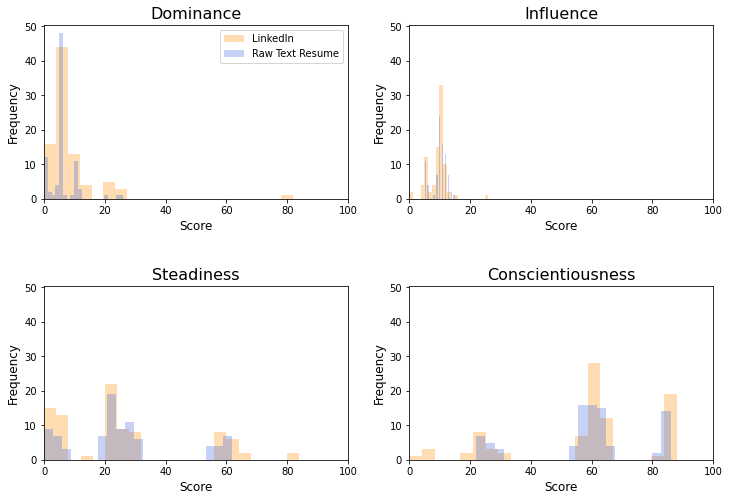

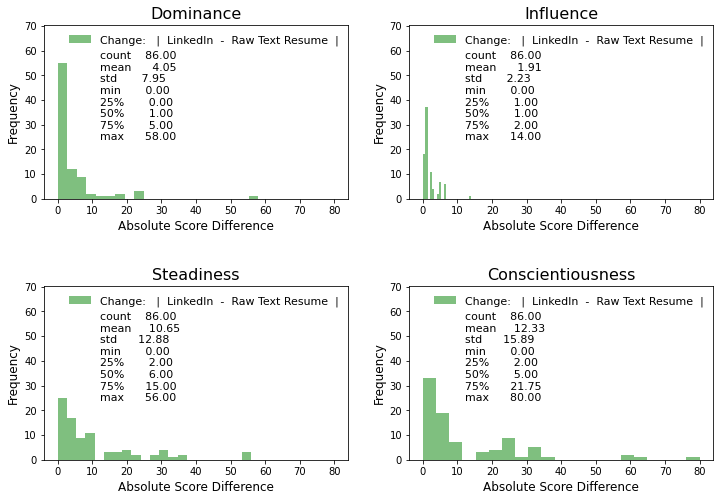

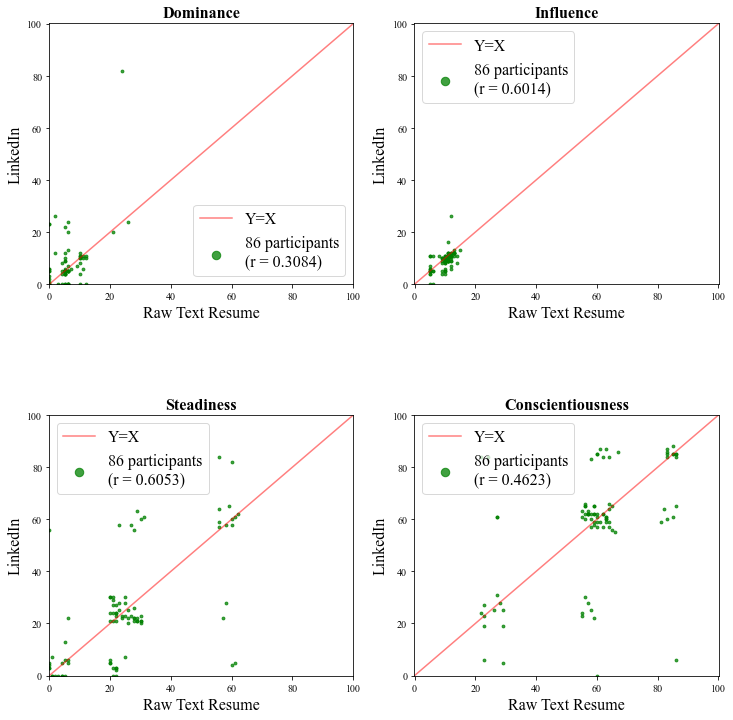

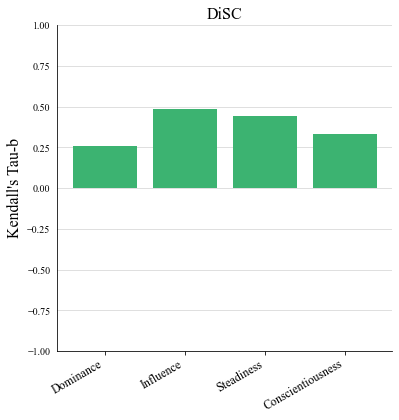

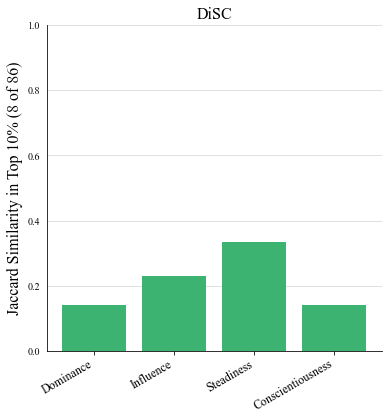

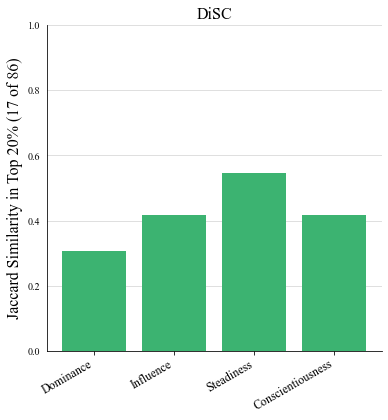

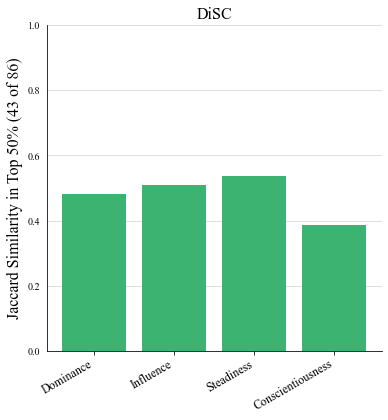

In [7]:
exp_n = len(set(CL1.index) & set(CRr1.index))
c_results['Source Context: Raw Text Resume vs. LinkedIn (N={})'\
          .format(exp_n)] = stability_analysis(treat_df = CL1, 
                                                     treat_label=run_dict['CL1'],
                                                     ctrl_df = CRr1, 
                                                     ctrl_label = run_dict['CRr1'],
                                                     tool='crystal')

### Humantic: Baseline Resume (PDF) vs. LinkedIn URL

In [8]:
# exp_n = len(set(HL1.index) & set(HRi1.index))
# h_results['Source Context: De-Identified Resume vs. LinkedIn  (N={})'\
#           .format(exp_n)] = stability_analysis(treat_df = HL1, 
#                                                      treat_label=run_dict['HL1'],
#                                                      ctrl_df = HRi1, 
#                                                      ctrl_label = run_dict['HRi1'],
#                                                      tool='humantic')

### Humantic: Baseline Resume (PDF) vs. Twitter

In [9]:
# exp_n = len(set(HT1.index) & set(HRi1.index))
# h_results['Source Context: De-Identified Resume vs. Twitter (N={})'\
#           .format(exp_n)] = stability_analysis(treat_df =HT1, 
#                                                      treat_label=run_dict['HT1'],
#                                                      ctrl_df = HRi1, 
#                                                      ctrl_label = run_dict['HRi1'],
#                                                      tool='humantic')

### Humantic: LinkedIn URL vs. Twitter

In [10]:
# exp_n = len(set(HT1.index) & set(HL1.index))
# h_results['Source Context: LinkedIn vs. Twitter (N={})'\
#           .format(exp_n)] = stability_analysis(treat_df = HT1, 
#                                                      treat_label=run_dict['HT1'],
#                                                      ctrl_df = HL1, 
#                                                      ctrl_label = run_dict['HL1'],
#                                                      tool='humantic')

# Experiment 1: Formatting Comparisons (using baseline resumes)

### Crystal: Baseline resume (raw text) vs. PDF

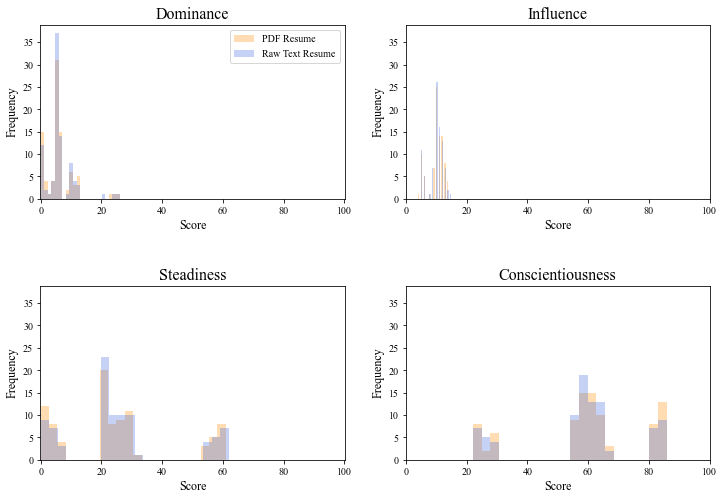

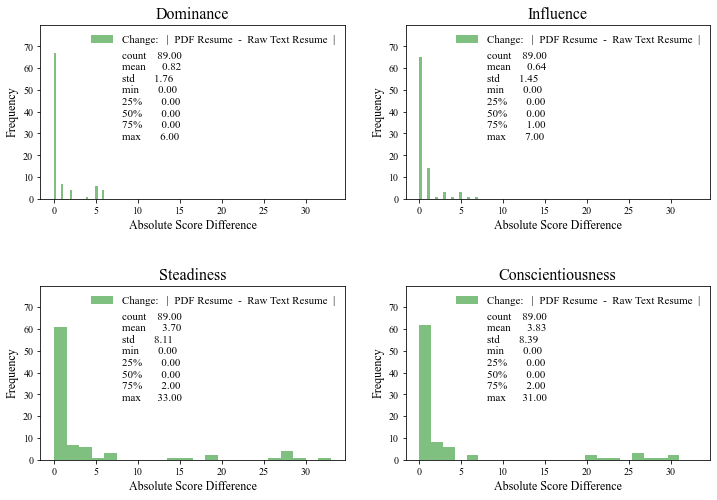

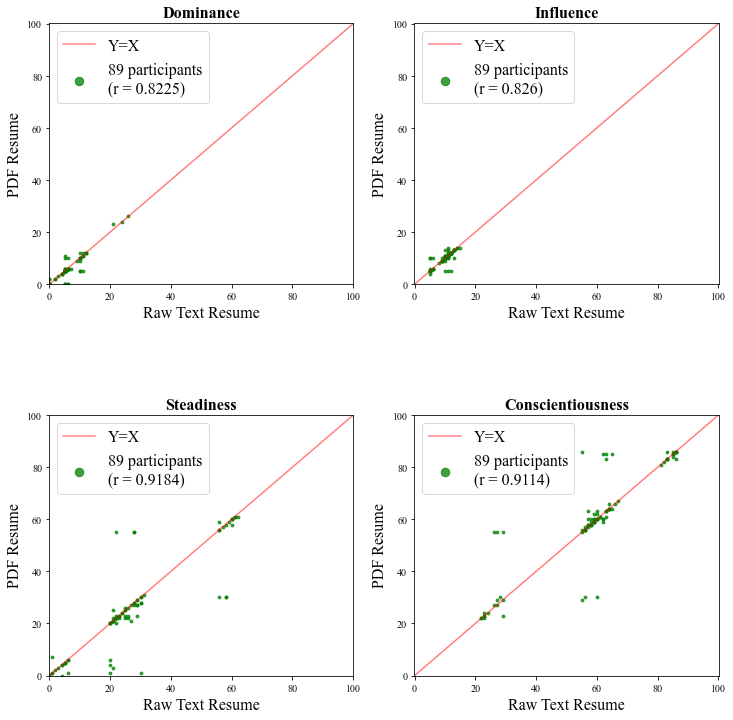

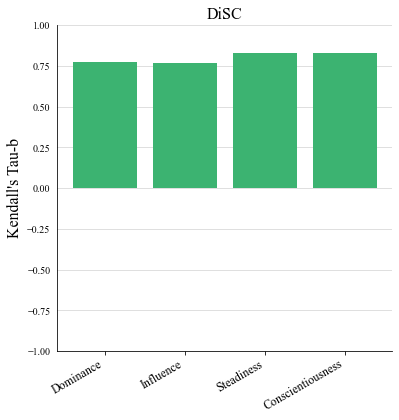

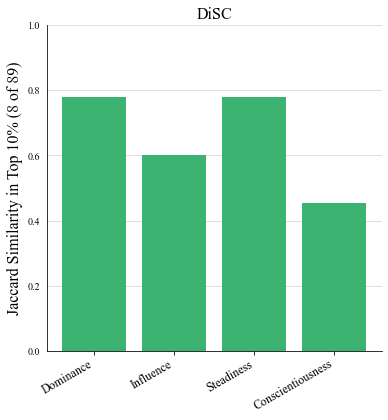

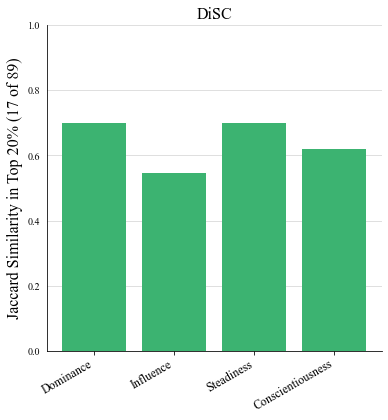

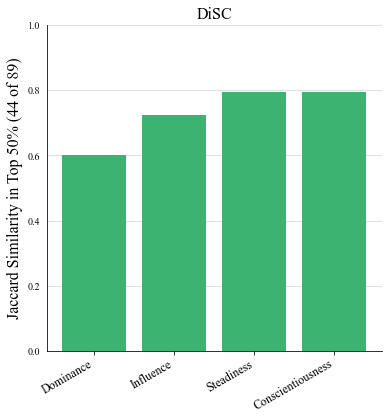

In [11]:
exp_n = len(set(CRp1.index) & set(CRr1.index))
c_results['File Format: Raw Text Resume vs. PDF Resume (N={})'\
          .format(exp_n)] = stability_analysis(treat_df = CRp1, 
                                                 treat_label=run_dict['CRp1'],
                                                 ctrl_df = CRr1, 
                                                 ctrl_label = run_dict['CRr1'],
                                                 tool='crystal')

### Humantic: Baseline resume (PDF) vs. DOCX

In [12]:
# exp_n = len(set(HRi1.index) & set(HRd1.index))
# h_results['File Format: De-Identified Resume vs. DOCX Resume (N={})'\
#           .format(exp_n)] = stability_analysis(treat_df = HRd1, 
#                                                  treat_label=run_dict['HRd1'],
#                                                  ctrl_df = HRi1, 
#                                                  ctrl_label = run_dict['HRi1'],
#                                                  tool='humantic')

# Experiment 2: Embedding LI Link into Resume

### Humantic: Baseline Resume vs. Resume with LI embedded

In [13]:
# exp_n = len(set(HRi1.index) & set(HRu1.index))
# h_results['URL Embedding: De-Identified Resume vs. URL-Embedded Resume (N={})'\
#           .format(exp_n)] = stability_analysis(treat_df = HRu1, 
#                                                  treat_label=run_dict['HRu1'],
#                                                  ctrl_df = HRi1, 
#                                                  ctrl_label = run_dict['HRi1'],
#                                                  tool='humantic')

### Humantic: Resume with LI embedded vs. LinkedIn URL

In [14]:
# exp_n = len(set(HL1.index) & set(HRu1.index))
# h_results['Source Context: LinkedIn vs. URL-Embedded Resume (N={})'\
#           .format(exp_n)] = stability_analysis(treat_df = HRu1, 
#                                                  treat_label=run_dict['HRu1'],
#                                                  ctrl_df = HL1, 
#                                                  ctrl_label = run_dict['HL1'],
#                                                  tool='humantic')

# Experiment 3: Identical Inputs (using baseline resume)

### Crystal: Baseline Resume (raw text) back-to-back

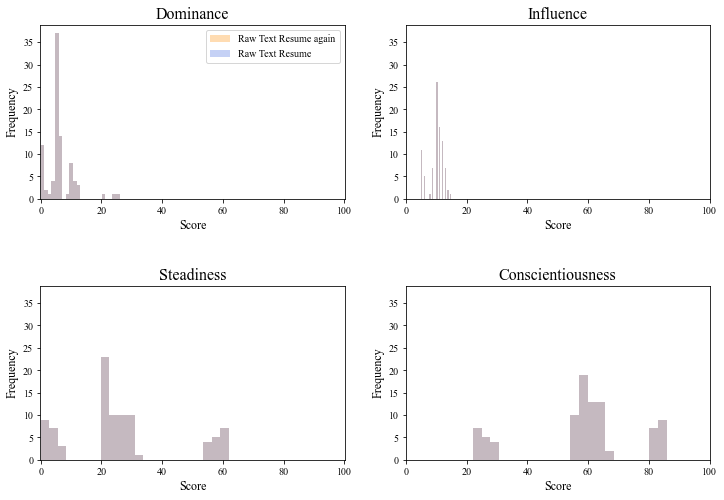

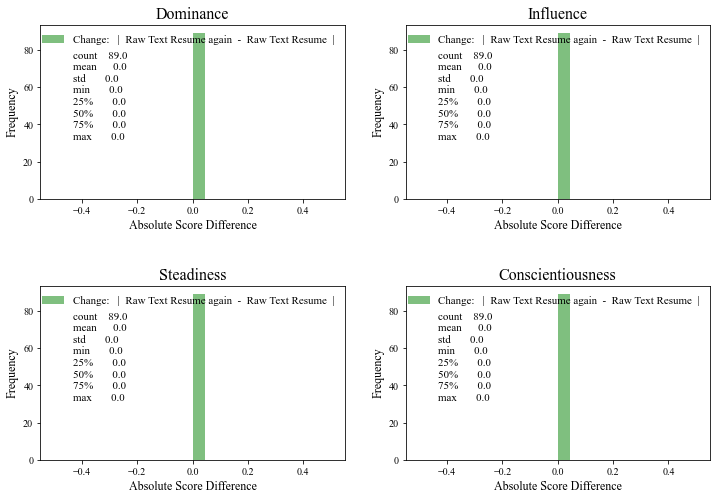

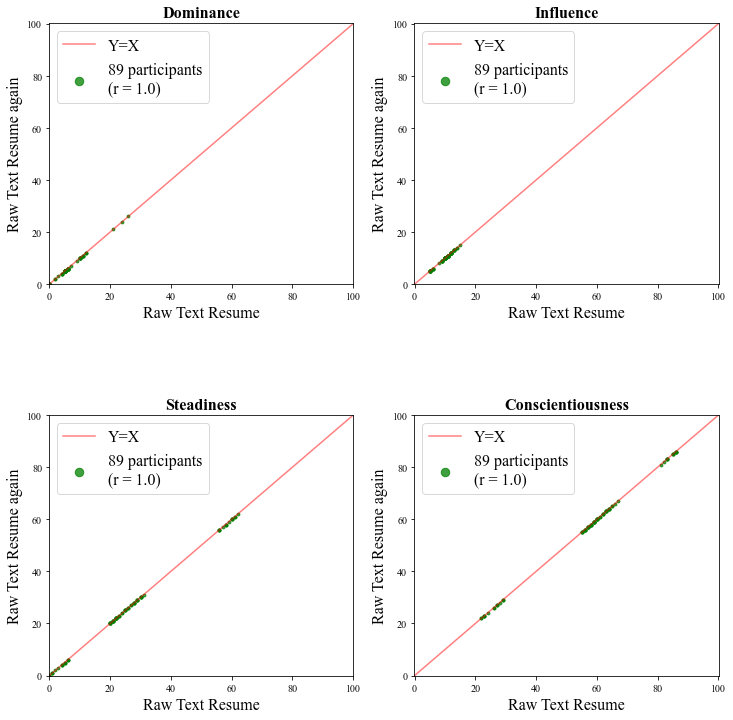

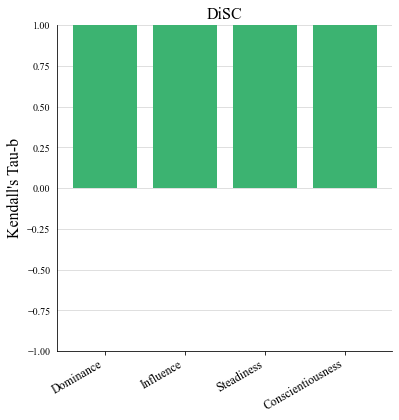

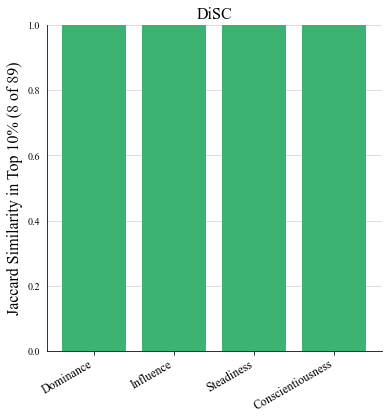

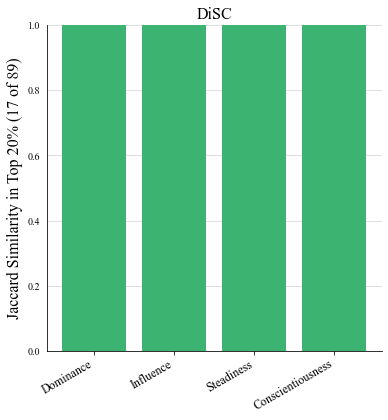

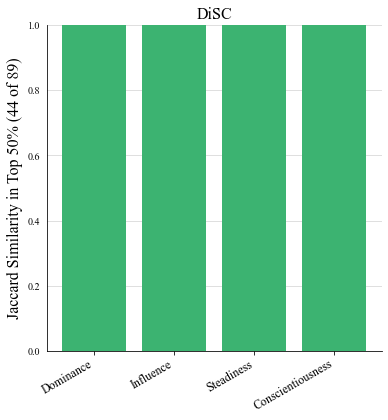

In [15]:
exp_n = len(set(CRr3.index) & set(CRr2.index))
c_results['Reproducibility: Raw Text Resume back-to-back (N={})'\
          .format(exp_n)] = stability_analysis(treat_df = CRr3, 
                                                 treat_label='Raw Text Resume again',
                                                 ctrl_df = CRr2, 
                                                 ctrl_label = 'Raw Text Resume',
                                                 tool='crystal')   

### Crystal: Baseline Resume (raw text) 31 days apart

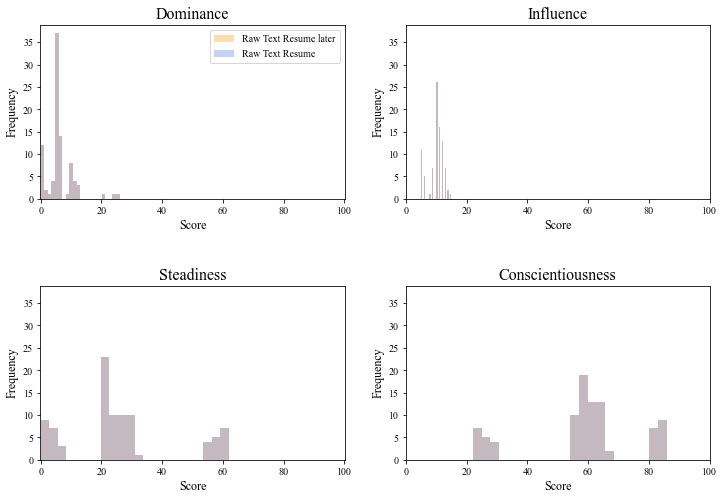

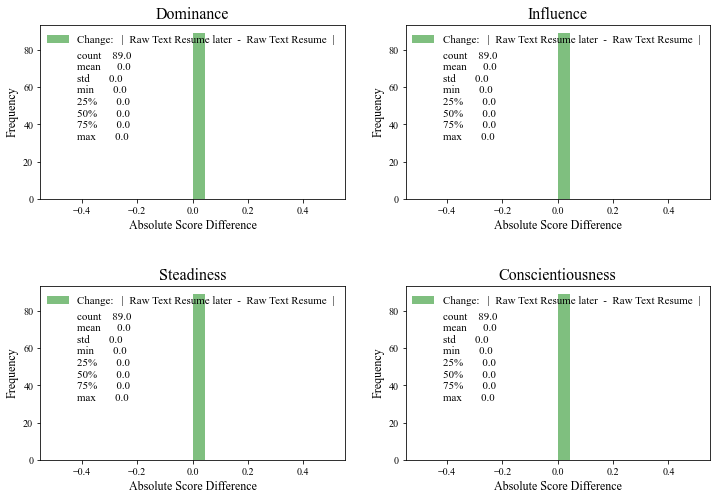

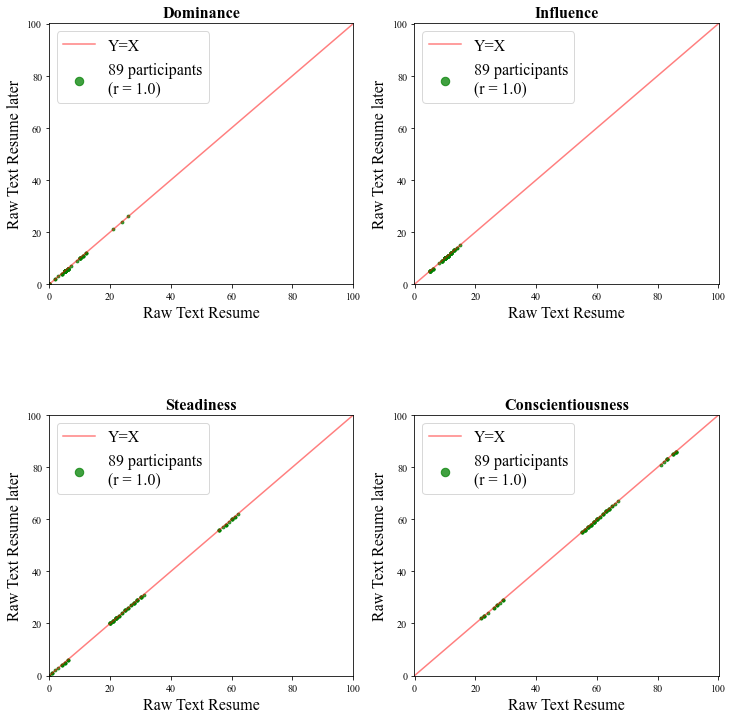

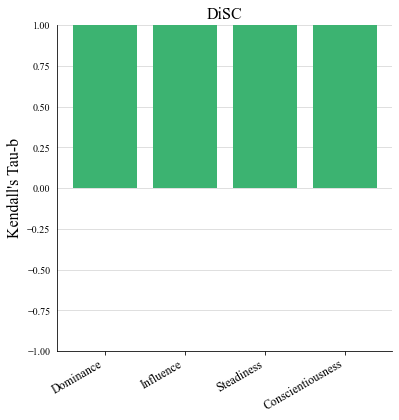

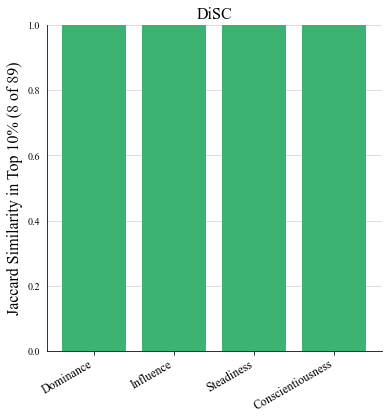

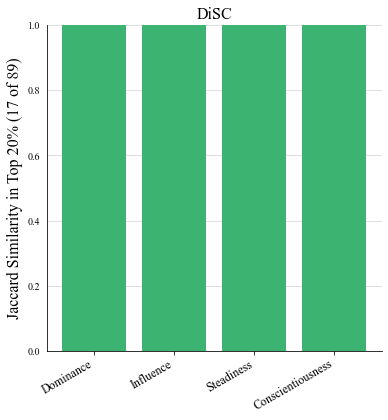

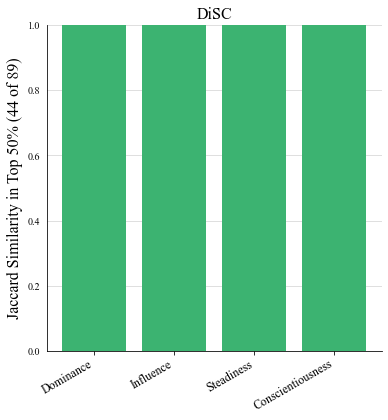

In [16]:
exp_n = len(set(CRr1.index) & set(CRr2.index))
c_results['Algorithm-Time: Raw Text Resume 31 days apart (N={})'\
          .format(exp_n)] = stability_analysis(treat_df = CRr2, 
                                               treat_label='Raw Text Resume later',
                                               ctrl_df = CRr1, 
                                               ctrl_label = 'Raw Text Resume',
                                               tool='crystal')

### Humantic: Baseline Resume (PDF) back-to-back

In [17]:
# exp_n = len(set(HRi3.index) & set(HRi2.index))
# h_results['Algorithm-Time: De-Identified Resume 31 days apart (N={})'\
#           .format(len(exp_df))] = stability_analysis(treat_df = HRi3, 
#                                                treat_label='De-Identified Resume again',
#                                                ctrl_df = HRi2, 
#                                                ctrl_label = 'De-Identified Resume',
#                                                tool='humantic')

### Humantic: Baseline Resume (PDF) 31 days apart

In [18]:
# exp_n = len(set(HRi1.index) & set(HRi2.index))
# h_results['Reproducibility: De-Identified Resume back-to-back  (N={})'\
#           .format(exp_n)] = stability_analysis(treat_df = HRi2, 
#                                                treat_label='De-Identified Resume later',
#                                                ctrl_df = HRi1, 
#                                                ctrl_label = 'De-Identified Resume',
#                                                tool='humantic')

# Experiment 4 : Platform Comparisons (using original resumes)

### Crystal: PDF Resume vs. LinkedIn URL (All Participants)

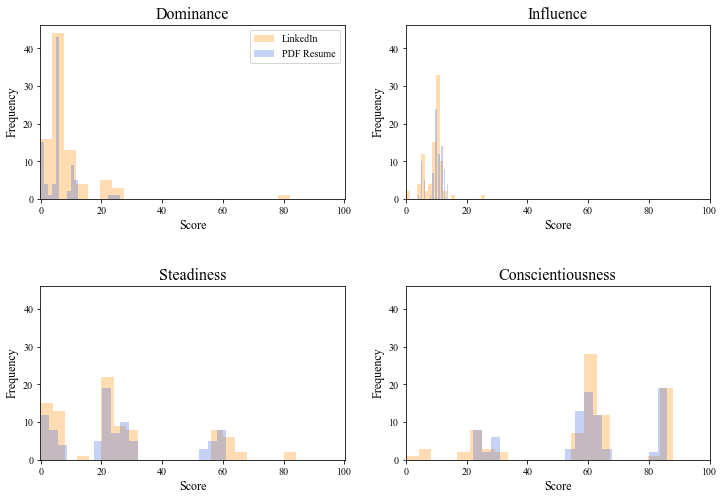

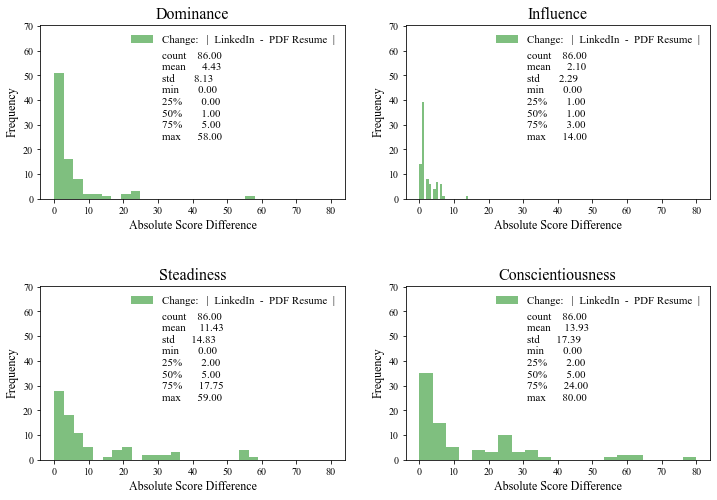

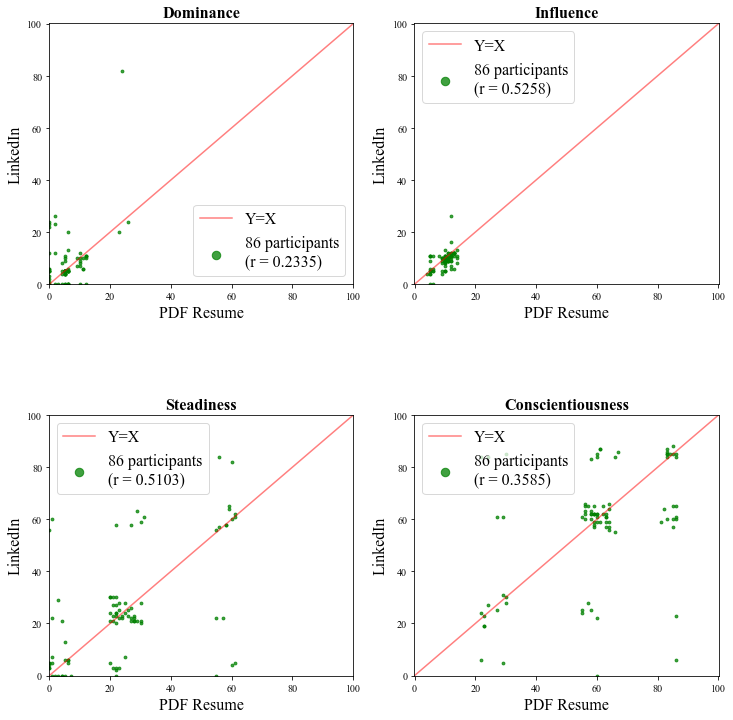

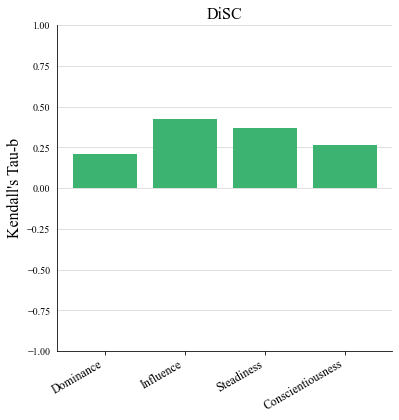

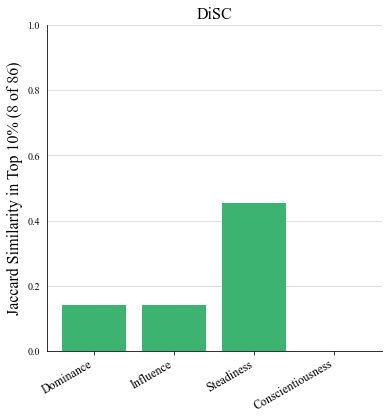

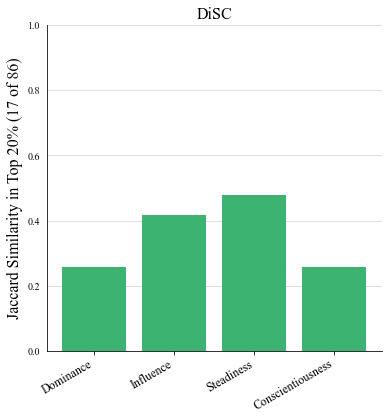

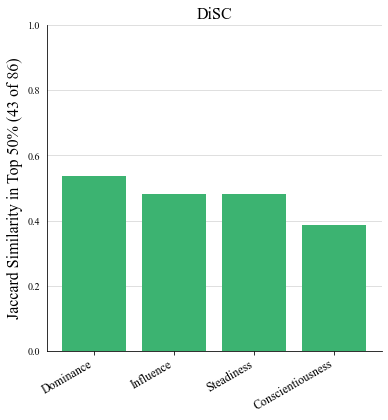

In [19]:
exp_n = len(set(CL1.index) & set(CRp1.index))
c_results['Source Context: PDF Resume vs. LinkedIn (N={})'\
          .format(exp_n)] = stability_analysis(treat_df = CL1, 
                                                   treat_label=run_dict['CL1'],
                                                   ctrl_df = CRp1, 
                                                   ctrl_label = run_dict['CRp1'],
                                                   tool='crystal')

### Crystal: PDF Resume vs. LinkedIn URL (Limit to Participants with LI Embedded in Resume)

In [20]:
# exp_df = pd.read_csv('Experiment4_repurposeFall_crystal/crystal_repurposeFall_linkedin_in_resume_cohort.csv')
# c_repurpose_LI_embed = stability_analysis(exp_df, tool='crystal', treat='linkedin', ctrl='resume')

### Crystal: Original Resume vs. LinkedIn URL (Limit to Participants without LI Embedded in Resume)

In [21]:
# exp_df = pd.read_csv('Experiment4_repurposeFall_crystal/crystal_repurposeFall_NO_linkedin_in_resume_cohort.csv')
# c_repurpose_no_LI_embed = stability_analysis(exp_df, tool='crystal', treat='linkedin', ctrl='resume') 

### Humantic: Original Resume vs. LinkedIn URL (All Participants)

In [22]:
# exp_n = len(set(HL1.index) & set(HRo1.index))
# h_results['Source Context: Original Resume vs. LinkedIn (N={})'\
#           .format(len(exp_df))] = stability_analysis(treat_df = HL1, 
#                                                    treat_label=run_dict['HL1'],
#                                                    ctrl_df = HRo1, 
#                                                    ctrl_label = run_dict['HRo1'],
#                                                    tool='humantic')

### Humantic: Original Resume vs. LinkedIn URL (Limit to Participants with LI Embedded in Resume)

In [23]:
# exp_df = pd.read_csv('Experiment4_repurposeFall_Humantic/Humantic_repurposeFall_linkedin_in_resume_cohort.csv')
# h_repurpose_LI_embed = stability_analysis(exp_df, tool='humantic', treat='linkedin', ctrl='resume')

### Humantic: Original Resume vs. LinkedIn URL (Limit to Participants without LI Embedded in Resume)

In [24]:
# exp_df = pd.read_csv('Experiment4_repurposeFall_Humantic/Humantic_repurposeFall_NO_linkedin_in_resume_cohort.csv')
# h_repurpose_no_LI_embed = stability_analysis(exp_df, tool='humantic', treat='linkedin', ctrl='resume')

### Humantic: Original Resume vs. Twitter

In [25]:
# exp_n = len(set(HT1.index) & set(HRo1.index))
# h_results['Source Context: Original Resume vs. Twitter (N={})'\
#           .format(exp_n)] = stability_analysis(treat_df = HT1, 
#                                                    treat_label=run_dict['HT1'],
#                                                    ctrl_df = HRo1, 
#                                                    ctrl_label = run_dict['HRo1'],
#                                                    tool='humantic')

# Experiment 5: Comparisons Across Participant-Time (Test-Retest)

### Crystal: Original LinkedIn URL run vs. LinkedIn URL refreshed 8-10 months later

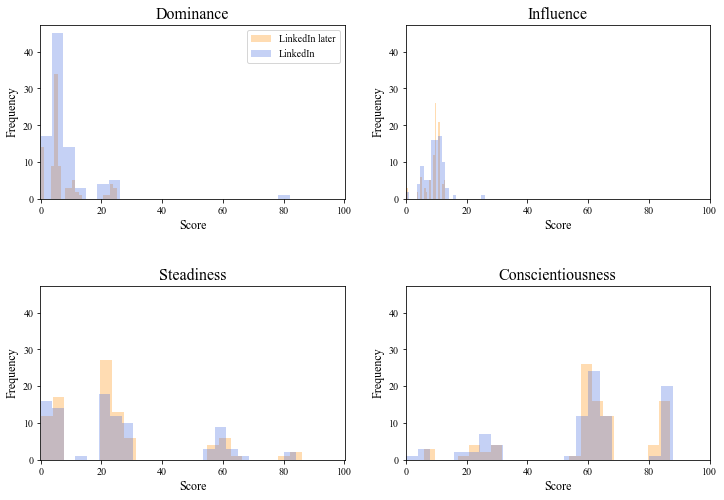

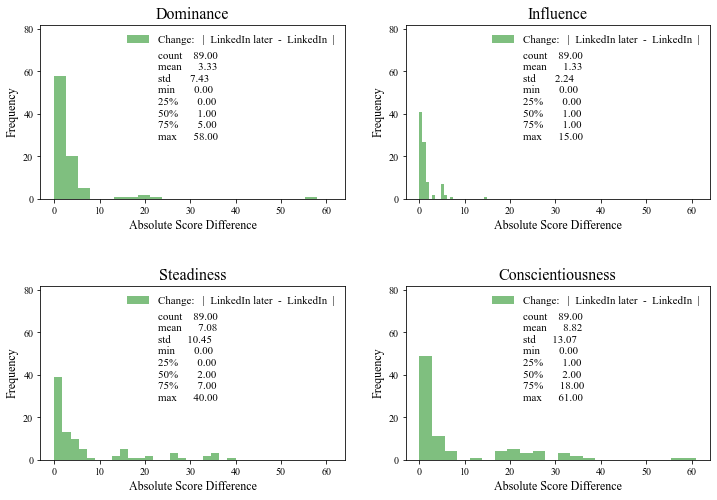

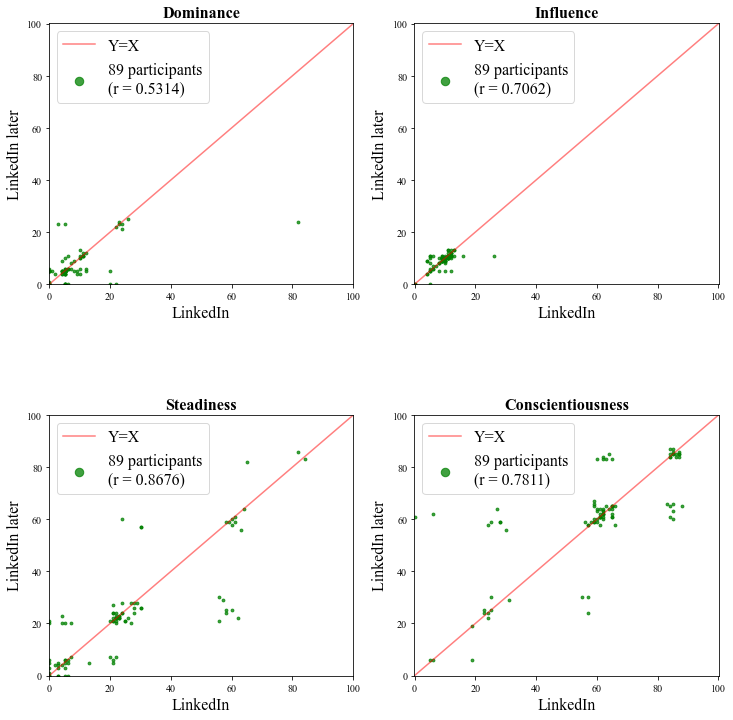

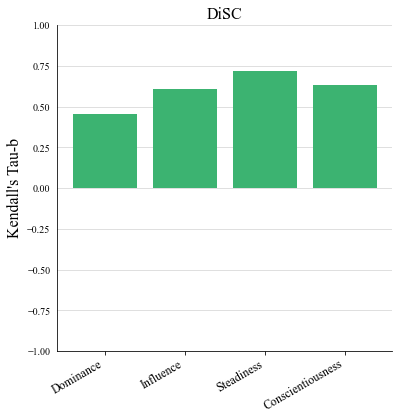

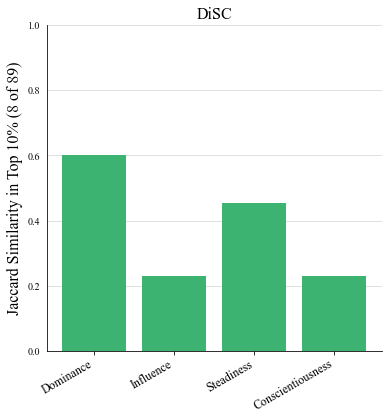

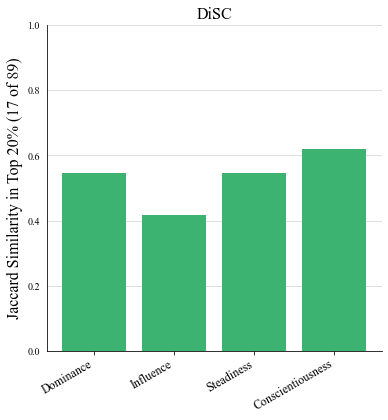

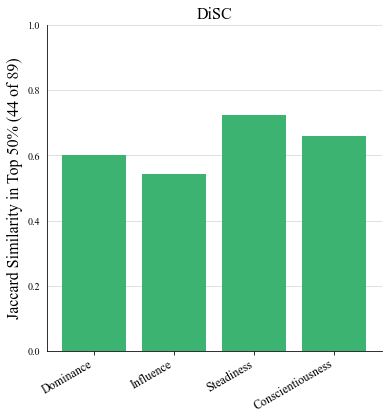

In [26]:
exp_n = len(set(CL1.index) & set(CL2.index))
c_results['Participant-Time: LinkedIn 8-10 months apart (N={})'\
          .format(exp_n)] = stability_analysis(treat_df = CL2, 
                                                   treat_label='LinkedIn later',
                                                   ctrl_df = CL1, 
                                                   ctrl_label = 'LinkedIn',
                                                   tool='crystal')

### Humantic: Original LinkedIn URL run vs. LinkedIn URL refreshed 7-9 months later

In [27]:
# exp_n = len(set(HL1.index) & set(HL2.index))
# h_results['Participant-Time: LinkedIn 7-9 months apart (N={})'\
#           .format(exp_n)] = stability_analysis(treat_df = HL2, 
#                                                treat_label='LinkedIn later',
#                                                ctrl_df = HL1, 
#                                                ctrl_label = 'LinkedIn',
#                                                tool='humantic')

### Humantic: Original Twitter run vs. Twitter refreshed 7-9 months later

In [28]:
# exp_n = len(set(HL1.index) & set(HL2.index))
# h_results['Participant-Time: Twitter 7-9 months apart (N={})'\
#           .format(exp_n)] = stability_analysis(treat_df = HT2, 
#                                                treat_label='Twitter later',
#                                                ctrl_df = HT1, 
#                                                ctrl_label = 'Twitter',
#                                                tool='humantic')

# Create and Save Metric-Specific Results Dataframes

In [29]:
def save_results_tables(results, all_traits_simple, l1_cols):
    
    # Correlation Table
    corr_rows = [exp['corr'] for exp in results.values()]
    corr_df = pd.DataFrame(corr_rows, columns = [x for x in all_traits_simple if x!="Confidence Score"], 
                           index=results.keys())
    #corr_df.to_csv(os.path.join(results_path, pathlib.Path('Spearmans_Correlation.csv')), index_label="Experiment")
    print("SPEARMAN\'S CORRELATION")
    display(corr_df)
    
    #Wilcoxon Table
    wc_iters = [results.keys(), ['W', 'p']]
    wc_ind = pd.MultiIndex.from_product(wc_iters, names=["Experiment", "One-tailed Wilcoxon"])
    wc_rows = []
    for exp in results.values():
        row = [exp['W']]
        row = row + [exp['p']]
        wc_rows = wc_rows+row
    wc_df = pd.DataFrame(wc_rows, columns = [x for x in all_traits_simple if x!="Confidence Score"], index=wc_ind)
    #wc_df.to_csv(os.path.join(results_path, pathlib.Path('Wilcoxon.csv')))
    print("\nWILCOXON SIGNED RANK TEST")
    display(wc_df)
    
    #Absolute Change Table
    change_iters = [results.keys(), ['min', 'med', 'max']]
    change_ind = pd.MultiIndex.from_product(change_iters, names=["Experiment", "Absolute Difference"])
    change_rows = []
    for exp in results.values():
        row = [exp['min']]
        row = row + [exp['med']]
        row = row + [exp['max']]
        change_rows = change_rows+row
    change_df = pd.DataFrame(change_rows, columns = [x for x in all_traits_simple], index=change_ind)
    #change_df.to_csv(os.path.join(results_path, pathlib.Path('Absolute_Difference.csv')))
    print("\nABSOLUTE DIFFERENCE")
    display(change_df)
    
    #Jaccard Table
    jacc_iters = [results.keys(), ['10%', '20%', '50%']]
    jacc_ind = pd.MultiIndex.from_product(jacc_iters, names=["Experiment", "Selection set size"])
    jacc_rows = []
    for exp in results.values():
        row = [exp['jacc_10']]
        row = row + [exp['jacc_20']]
        row = row + [exp['jacc_50']]
        jacc_rows = jacc_rows+row
    jacc_df = pd.DataFrame(jacc_rows, columns = [x for x in all_traits_simple if x!="Confidence Score"], index=jacc_ind)
    #jacc_df.to_csv(os.path.join(results_path, pathlib.Path('Jaccard.csv')))
    print('\nJACCARD SIMILARITY')
    display(jacc_df)
    
    # Kendall's Tau Table
    kt_rows = [exp['KT'] for exp in results.values()]
    kt_df = pd.DataFrame(kt_rows, columns = [x for x in all_traits_simple if x!="Confidence Score"], 
                         index=results.keys())
    #kt_df.to_csv(os.path.join(results_path, pathlib.Path('Kendalls_Tau-b.csv')), index_label="Experiment")
    display(kt_df)
    
    # L1 Norm Table (using maximums for normalization)
    l1_iters = [results.keys(), ['mean', 'stdev']]
    l1_ind = pd.MultiIndex.from_product(l1_iters, names=["Experiment", "L1 Distance"])
    l1_rows = []
    for exp in results.values():
        l1_arr = np.array(exp['L1_max'])
        row = [l1_arr.mean(axis=1)] + [l1_arr.std(axis=1)]
        l1_rows = l1_rows+row
    l1_df = pd.DataFrame(l1_rows, index=l1_ind, columns = l1_cols)
    #l1_df.to_csv(os.path.join(results_path, pathlib.Path('L1_Distance_full.csv')))
    print('\nMANHATTAN DISTANCE (L1), FULL RANGE OF SCALE')
    display(l1_df)
    
    # L1 Norm Table (using ranges for normalization)
    l1_iters = [results.keys(), ['mean', 'stdev']]
    l1_ind = pd.MultiIndex.from_product(l1_iters, names=["Experiment", "L1 Distance"])
    l1_rows = []
    for exp in results.values():
        l1_arr = np.array(exp['L1_range'])
        row = [l1_arr.mean(axis=1)] + [l1_arr.std(axis=1)]
        l1_rows = l1_rows+row
    l1_df = pd.DataFrame(l1_rows, index=l1_ind, columns = l1_cols)
    #l1_df.to_csv(os.path.join(results_path, pathlib.Path('L1_Distance_obs.csv')))
    print('\nMANHATTAN DISTANCE (L1), OBSERVED RANGE')
    display(l1_df)
    
    # Mean and median table
    avg_iters = [results.keys(), ['mean', 'mean', 'median', 'median']]
    avg_ind = pd.MultiIndex.from_product(avg_iters, names=["Experiment", "Average"])
    avg_rows = []
    for exp in results.values():
        row = [[exp['control_run']] + list(exp['overall_mean_control'].values)]
        row = row + [[exp['treatment_run']] + list(exp['overall_mean_treatment'].values)]
        row = row + [[exp['control_run']] + list(exp['overall_median_control'].values)]
        row = row + [[exp['treatment_run']] + list(exp['overall_median_treatment'].values)]
        avg_rows = avg_rows+row
    avg_df = pd.DataFrame(avg_rows, index=avg_ind, 
                          columns=['Run']+all_traits_simple)
    #avg_df.to_csv(os.path.join(results_path, pathlib.Path('Means_and_Medians.csv')))
    print('\nMEANS AND MEDIANS OF EACH RUN')
    display(avg_df)
    
    return(corr_df, wc_df, change_df, jacc_df, kt_df, l1_df, avg_df)

In [30]:
# paths to results folders
# h_results_path = os.path.join(pathlib.Path(os.getcwd()).parent.parent.absolute(), pathlib.Path('results/humantic'))
# c_results_path = os.path.join(pathlib.Path(os.getcwd()).parent.parent.absolute(), pathlib.Path('results/crystal'))

# Column names for L1 Distance table
h_l1_cols = ['DISC (4 scores, 0-10)', 
             'Big Five (5 scores, 0-10)',
             'Behavioral Work Factors (7 scores, 0-10)',
             'Confidence Score (1 score, 0-100)']
c_l1_cols = ['DISC (4 scores, 0-100, sum to 100)']

In [31]:
# Crystal Results
c_corr_df, c_wc_df, c_change_df, c_jacc_df, c_kt_df, c_l1_df, c_avg_df = save_results_tables(c_results,
                                                                                   crystal_all_traits_simple, 
                                                                                   c_l1_cols)

SPEARMAN'S CORRELATION


,Dominance,Influence,Steadiness,Conscientiousness
Source Context: Raw Text Resume vs. LinkedIn (N=86),0.308372,0.601421,0.605338,0.462264
File Format: Raw Text Resume vs. PDF Resume (N=89),0.822451,0.826028,0.918406,0.911401
Reproducibility: Raw Text Resume back-to-back (N=89),1.000000,1.000000,1.000000,1.000000
Algorithm-Time: Raw Text Resume 31 days apart (N=89),1.000000,1.000000,1.000000,1.000000
Source Context: PDF Resume vs. LinkedIn (N=86),0.233459,0.525754,0.510262,0.358494
Participant-Time: LinkedIn 8-10 months apart (N=89),0.531372,0.706181,0.867640,0.781113



WILCOXON SIGNED RANK TEST


Dominance  \
Experiment                                         One-tailed Wilcoxon               
Source Context: Raw Text Resume vs. LinkedIn (N... W                    681.000000   
                                                   p                      0.337307   
File Format: Raw Text Resume vs. PDF Resume (N=89) W                    106.000000   
                                                   p                      0.502560   
Reproducibility: Raw Text Resume back-to-back (... W                           NaN   
                                                   p                           NaN   
Algorithm-Time: Raw Text Resume 31 days apart (... W                           NaN   
                                                   p                           NaN   
Source Context: PDF Resume vs. LinkedIn (N=86)     W                    833.500000   
                                                   p                      0.419034   
Participant-Time: LinkedIn 8-10 months apart (N... W                    626.500000   
                                                   p                      0.729940   

                                                                         Influence  \
Experiment                                         One-tailed Wilcoxon               
Source Context: Raw Text Resume vs. LinkedIn (N... W                    615.500000   
                                                   p                      0.000505   
File Format: Raw Text Resume vs. PDF Resume (N=89) W                    122.500000   
                                                   p                      0.420843   
Reproducibility: Raw Text Resume back-to-back (... W                           NaN   
                                                   p                           NaN   
Algorithm-Time: Raw Text Resume 31 days apart (... W                           NaN   
                                                   p                           NaN   
Source Context: PDF Resume vs. LinkedIn (N=86)     W                    747.500000   
                                                   p                      0.001178   
Participant-Time: LinkedIn 8-10 months apart (N... W                    545.000000   
                                                   p                      0.651781   

                                                                         Steadiness  \
Experiment                                         One-tailed Wilcoxon                
Source Context: Raw Text Resume vs. LinkedIn (N... W                    1521.500000   
                                                   p                       0.636386   
File Format: Raw Text Resume vs. PDF Resume (N=89) W                     158.500000   
                                                   p                       0.017266   
Reproducibility: Raw Text Resume back-to-back (... W                            NaN   
                                                   p                            NaN   
Algorithm-Time: Raw Text Resume 31 days apart (... W                            NaN   
                                                   p                            NaN   
Source Context: PDF Resume vs. LinkedIn (N=86)     W                    1501.500000   
                                                   p                       0.700989   
Participant-Time: LinkedIn 8-10 months apart (N... W                     953.500000   
                                                   p                       0.330464   

                                                                        Conscientiousness  
Experiment                                         One-tailed Wilcoxon                     
Source Context: Raw Text Resume vs. LinkedIn (N... W                          1441.500000  
                                                   p                             0.760484  
File Format: Raw Text Resume vs. PDF Resume (N=89) W                        


ABSOLUTE DIFFERENCE


Dominance  \
Experiment                                         Absolute Difference              
Source Context: Raw Text Resume vs. LinkedIn (N... min                        0.0   
                                                   med                        1.0   
                                                   max                       58.0   
File Format: Raw Text Resume vs. PDF Resume (N=89) min                        0.0   
                                                   med                        0.0   
                                                   max                        6.0   
Reproducibility: Raw Text Resume back-to-back (... min                        0.0   
                                                   med                        0.0   
                                                   max                        0.0   
Algorithm-Time: Raw Text Resume 31 days apart (... min                        0.0   
                                                   med                        0.0   
                                                   max                        0.0   
Source Context: PDF Resume vs. LinkedIn (N=86)     min                        0.0   
                                                   med                        1.0   
                                                   max                       58.0   
Participant-Time: LinkedIn 8-10 months apart (N... min                        0.0   
                                                   med                        1.0   
                                                   max                       58.0   

                                                                        Influence  \
Experiment                                         Absolute Difference              
Source Context: Raw Text Resume vs. LinkedIn (N... min                        0.0   
                                                   med                        1.0   
                                                   max                       14.0   
File Format: Raw Text Resume vs. PDF Resume (N=89) min                        0.0   
                                                   med                        0.0   
                                                   max                        7.0   
Reproducibility: Raw Text Resume back-to-back (... min                        0.0   
                                                   med                        0.0   
                                                   max                        0.0   
Algorithm-Time: Raw Text Resume 31 days apart (... min                        0.0   
                                                   med                        0.0   
                                                   max                        0.0   
Source Context: PDF Resume vs. LinkedIn (N=86)     min                        0.0   
                                                   med                        1.0   
                                                   max                       14.0   
Participant-Time: LinkedIn 8-10 months apart (N... min                        0.0   
                                                   med                        1.0   
                                                   max                       15.0   

                                                                        Steadiness  \
Experiment                                         Absolute Difference               
Source Context: Raw Text Resume vs. LinkedIn (N... min                         0.0   
                                                   med                         6.0   
                                                   max                        56.0   
File Format: Raw Text Resume vs. PDF Resume (N=89) min                         0.0   
                                                   med                         0.0   
                                                   max              


JACCARD SIMILARITY


Dominance  \
Experiment                                         Selection set size              
Source Context: Raw Text Resume vs. LinkedIn (N... 10%                  0.142857   
                                                   20%                  0.307692   
                                                   50%                  0.482759   
File Format: Raw Text Resume vs. PDF Resume (N=89) 10%                  0.777778   
                                                   20%                  0.700000   
                                                   50%                  0.600000   
Reproducibility: Raw Text Resume back-to-back (... 10%                  1.000000   
                                                   20%                  1.000000   
                                                   50%                  1.000000   
Algorithm-Time: Raw Text Resume 31 days apart (... 10%                  1.000000   
                                                   20%                  1.000000   
                                                   50%                  1.000000   
Source Context: PDF Resume vs. LinkedIn (N=86)     10%                  0.142857   
                                                   20%                  0.259259   
                                                   50%                  0.535714   
Participant-Time: LinkedIn 8-10 months apart (N... 10%                  0.600000   
                                                   20%                  0.545455   
                                                   50%                  0.600000   

                                                                       Influence  \
Experiment                                         Selection set size              
Source Context: Raw Text Resume vs. LinkedIn (N... 10%                  0.230769   
                                                   20%                  0.416667   
                                                   50%                  0.508772   
File Format: Raw Text Resume vs. PDF Resume (N=89) 10%                  0.600000   
                                                   20%                  0.545455   
                                                   50%                  0.725490   
Reproducibility: Raw Text Resume back-to-back (... 10%                  1.000000   
                                                   20%                  1.000000   
                                                   50%                  1.000000   
Algorithm-Time: Raw Text Resume 31 days apart (... 10%                  1.000000   
                                                   20%                  1.000000   
                                                   50%                  1.000000   
Source Context: PDF Resume vs. LinkedIn (N=86)     10%                  0.142857   
                                                   20%                  0.416667   
                                                   50%                  0.482759   
Participant-Time: LinkedIn 8-10 months apart (N... 10%                  0.230769   
                                                   20%                  0.416667   
                                                   50%                  0.543860   

                                                                       Steadiness  \
Experiment                                         Selection set size               
Source Context: Raw Text Resume vs. LinkedIn (N... 10%                   0.333333   
                                                   20%                   0.545455   
                                                   50%                   0.535714   
File Format: Raw Text Resume vs. PDF Resume (N=89) 10%                   0.777778   
                                                   20%                   0.700000   
                                                   50%                   0.795918   
Reproducibility: Raw Text Res

,Dominance,Influence,Steadiness,Conscientiousness
Source Context: Raw Text Resume vs. LinkedIn (N=86),0.260530,0.484401,0.440605,0.331808
File Format: Raw Text Resume vs. PDF Resume (N=89),0.772784,0.767149,0.830827,0.830907
Reproducibility: Raw Text Resume back-to-back (N=89),1.000000,1.000000,1.000000,1.000000
Algorithm-Time: Raw Text Resume 31 days apart (N=89),1.000000,1.000000,1.000000,1.000000
Source Context: PDF Resume vs. LinkedIn (N=86),0.209653,0.422094,0.371437,0.261168
Participant-Time: LinkedIn 8-10 months apart (N=89),0.455866,0.609833,0.715777,0.631792



MANHATTAN DISTANCE (L1), FULL RANGE OF SCALE


DISC (4 scores, 0-100, sum to 100)
Experiment                                         L1 Distance                                    
Source Context: Raw Text Resume vs. LinkedIn (N... mean                                   0.072326
                                                   stdev                                  0.083142
File Format: Raw Text Resume vs. PDF Resume (N=89) mean                                   0.022472
                                                   stdev                                  0.048150
Reproducibility: Raw Text Resume back-to-back (... mean                                   0.000000
                                                   stdev                                  0.000000
Algorithm-Time: Raw Text Resume 31 days apart (... mean                                   0.000000
                                                   stdev                                  0.000000
Source Context: PDF Resume vs. LinkedIn (N=86)     mean                                   0.079738
                                                   stdev                                  0.091912
Participant-Time: LinkedIn 8-10 months apart (N... mean                                   0.051376
                                                   stdev                                  0.070372


MANHATTAN DISTANCE (L1), OBSERVED RANGE


DISC (4 scores, 0-100, sum to 100)
Experiment                                         L1 Distance                                    
Source Context: Raw Text Resume vs. LinkedIn (N... mean                                   0.097389
                                                   stdev                                  0.108824
File Format: Raw Text Resume vs. PDF Resume (N=89) mean                                   0.052315
                                                   stdev                                  0.110205
Reproducibility: Raw Text Resume back-to-back (... mean                                   0.000000
                                                   stdev                                  0.000000
Algorithm-Time: Raw Text Resume 31 days apart (... mean                                   0.000000
                                                   stdev                                  0.000000
Source Context: PDF Resume vs. LinkedIn (N=86)     mean                                   0.107337
                                                   stdev                                  0.119612
Participant-Time: LinkedIn 8-10 months apart (N... mean                                   0.068523
                                                   stdev                                  0.093427


MEANS AND MEDIANS OF EACH RUN


Run  \
Experiment                                         Average                          
Source Context: Raw Text Resume vs. LinkedIn (N... mean           Raw Text Resume   
                                                   mean                  LinkedIn   
                                                   median         Raw Text Resume   
                                                   median                LinkedIn   
File Format: Raw Text Resume vs. PDF Resume (N=89) mean           Raw Text Resume   
                                                   mean                PDF Resume   
                                                   median         Raw Text Resume   
                                                   median              PDF Resume   
Reproducibility: Raw Text Resume back-to-back (... mean           Raw Text Resume   
                                                   mean     Raw Text Resume again   
                                                   median         Raw Text Resume   
                                                   median   Raw Text Resume again   
Algorithm-Time: Raw Text Resume 31 days apart (... mean           Raw Text Resume   
                                                   mean     Raw Text Resume later   
                                                   median         Raw Text Resume   
                                                   median   Raw Text Resume later   
Source Context: PDF Resume vs. LinkedIn (N=86)     mean                PDF Resume   
                                                   mean                  LinkedIn   
                                                   median              PDF Resume   
                                                   median                LinkedIn   
Participant-Time: LinkedIn 8-10 months apart (N... mean                  LinkedIn   
                                                   mean            LinkedIn later   
                                                   median                LinkedIn   
                                                   median          LinkedIn later   

                                                            Dominance  \
Experiment                                         Average              
Source Context: Raw Text Resume vs. LinkedIn (N... mean      5.953488   
                                                   mean      7.790698   
                                                   median    5.000000   
                                                   median    5.000000   
File Format: Raw Text Resume vs. PDF Resume (N=89) mean      5.988764   
                                                   mean      5.797753   
                                                   median    5.000000   
                                                   median    5.000000   
Reproducibility: Raw Text Resume back-to-back (... mean      5.988764   
                                                   mean      5.988764   
                                                   median    5.000000   
                                                   median    5.000000   
Algorithm-Time: Raw Text Resume 31 days apart (... mean      5.988764   
                                                   mean      5.988764   
                                                   median    5.000000   
                                                   median    5.000000   
Source Context: PDF Resume vs. LinkedIn (N=86)     mean      5.802326   
                                                   mean      7.790698   
                                                   median    5.000000   
                                                   median    5.000000   
Participant-Time: LinkedIn 8-10 months apart (N... mean      7.786517   
                                                   mean      6.932584   
                                                   median    5.000000   
                                          

In [32]:
# # Humantic Results
# h_corr_df, h_wc_df, h_change_df, h_jacc_df, h_kt_df, h_l1_df, h_avg_df = save_results_tables(h_results, 
#                                                                                    humantic_all_traits_simple,
#                                                                                    h_l1_cols)

## Making and displaying correlation tables separated by score-type

In [33]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [34]:
# h_corr = h_corr_df.copy()

# # Parse index string
# h_corr['Experiment']=h_corr.index.map(lambda x: x.split(': ')[0])
# h_corr['Comparison']=h_corr.index.map(lambda x: x.split(': ')[1])
# h_corr['N']=h_corr['Comparison'].map(lambda x: int(x.split('(N=')[1][:-1]))
# h_corr['Comparison']=h_corr['Comparison'].map(lambda x: x.split(' (N=')[0])

# # Reorder according to experiment
exp_order_dict = {'Reproducibility': 0,
                  'Algorithm-Time': 1,
                  'Participant-Time': 2,
                  'File Format': 3,
                  'URL Embedding': 4,
                  'Profile Type': 5}
# h_corr.reset_index(drop=True, inplace=True)
# h_order = h_corr['Experiment'].map(exp_order_dict).sort_values().index
# h_corr = h_corr.loc[h_order]

# # Remove De-Identified Resume vs. Twitter
# h_corr = h_corr[h_corr.Comparison!='De-Identified Resume vs. Twitter']

# # Reverse name order of embed vs. LI
# h_corr.loc[h_corr.Comparison=='LinkedIn vs. URL-Embedded Resume', 'Comparison'] = 'URL-Embedded Resume vs. LinkedIn'

# # Remove LinkedIn vs. Twitter and append at bottom
# last_row = h_corr[h_corr.Comparison=='LinkedIn vs. Twitter']
# h_corr = h_corr[h_corr.Comparison!='LinkedIn vs. Twitter']
# h_corr = h_corr.append(last_row, ignore_index=True)

# # Reset index
# h_corr.reset_index(drop=True, inplace=True)

# # Display columns of interest in desired order
# h_corr_disc_and_ocean = h_corr[['Experiment', 'Comparison', 'N']+disc_traits_humantic+ocean_traits]
# h_corr_disc_and_ocean

In [35]:
# h_corr_disc = h_corr_disc_and_ocean.drop(columns=ocean_traits)

# print(h_corr_disc.to_latex(buf=None, columns=None, col_space=None, 
#                    header=True, index=False, na_rep='-', 
#                    formatters=None, float_format="%.4f", sparsify=None, 
#                    index_names=True, bold_rows=False, column_format=None, 
#                    longtable=None, escape=None, encoding=None, decimal='.', 
#                    multicolumn=None, multicolumn_format=None, multirow=None, 
#                    caption=None, label=None))

In [36]:
# h_corr_ocean = h_corr_disc_and_ocean.drop(columns=disc_traits)

# print(h_corr_ocean.to_latex(buf=None, columns=None, col_space=None, 
#                    header=True, index=False, na_rep='-', 
#                    formatters=None, float_format="%.4f", sparsify=None, 
#                    index_names=True, bold_rows=False, column_format=None, 
#                    longtable=None, escape=None, encoding=None, decimal='.', 
#                    multicolumn=None, multicolumn_format=None, multirow=None, 
#                    caption=None, label=None))

In [37]:
# orig_vs_li_sub_corr = pd.DataFrame(data=[[56]+h_repurpose_LI_embed['corr'], [28]+h_repurpose_no_LI_embed['corr']], 
#                          columns = ['N']+[x for x in humantic_all_traits_simple if x!="Confidence Score"],
#                         index = ['Original Resume vs. LinkedIn (limit to resumes with embedded LinkedIn URL)', 
#                                 'Original Resume vs. LinkedIn (limit to resumes without embedded LinkedIn URL)'])\
#                     [['N']+disc_traits+ocean_traits]
# orig_vs_li_sub_corr

In [38]:
# # How many people with embedded resumes had ANY change?
# orig_vs_li_sub_l1 = pd.DataFrame(np.array(h_repurpose_LI_embed['L1_max'])[:2,:].T, columns=['DISC', 'Big Five'])
# len(orig_vs_li_sub_l1[np.isclose(orig_vs_li_sub_l1.sum(axis=1), 0)==False])

In [39]:
c_corr =c_corr_df.copy()

# Parse index string
c_corr['Experiment']=c_corr.index.map(lambda x: x.split(': ')[0])
c_corr['Comparison']=c_corr.index.map(lambda x: x.split(': ')[1])
c_corr['N']=c_corr['Comparison'].map(lambda x: int(x.split('(N=')[1][:-1]))
c_corr['Comparison']=c_corr['Comparison'].map(lambda x: x.split(' (N=')[0])

# Order by Experiment
c_corr.reset_index(drop=True, inplace=True)
c_order = c_corr['Experiment'].map(exp_order_dict).sort_values().index
c_corr = c_corr.loc[c_order]

# Remove Raw Text Resume vs. LinkedIn
c_corr = c_corr[c_corr.Comparison!='Raw Text Resume vs. LinkedIn']

# Display columns in desired order
c_corr_disc = c_corr[['Experiment', 'Comparison', 'N']+disc_traits_crystal].reset_index(drop=True)
c_corr_disc

,Experiment,Comparison,N,Dominance,Influence,Steadiness,Conscientiousness
0,Reproducibility,Raw Text Resume back-to-back,89,1.000000,1.000000,1.000000,1.000000
1,Algorithm-Time,Raw Text Resume 31 days apart,89,1.000000,1.000000,1.000000,1.000000
2,Participant-Time,LinkedIn 8-10 months apart,89,0.531372,0.706181,0.867640,0.781113
3,File Format,Raw Text Resume vs. PDF Resume,89,0.822451,0.826028,0.918406,0.911401
4,Source Context,PDF Resume vs. LinkedIn,86,0.233459,0.525754,0.510262,0.358494


In [40]:
# print(c_corr_disc.to_latex(buf=None, columns=None, col_space=None, 
#                    header=True, index=False, na_rep='-', 
#                    formatters=None, float_format="%.4f", sparsify=None, 
#                    index_names=True, bold_rows=False, column_format=None, 
#                    longtable=None, escape=None, encoding=None, decimal='.', 
#                    multicolumn=None, multicolumn_format=None, multirow=None, 
#                    caption=None, label=None))

### Printing experiment-level summaries from lowest to highest corr

## Making and displaying mean-level significance tables separated by score-type

In [41]:
# h_wc = h_wc_df.copy()

# # Only display significance levels
# h_wc = h_wc[h_wc.index.get_level_values('One-tailed Wilcoxon')=='p']

# # Parse index string
# h_wc['Experiment']=h_wc.index.get_level_values('Experiment').map(lambda x: x.split(': ')[0])
# h_wc['Comparison']=h_wc.index.get_level_values('Experiment').map(lambda x: x.split(': ')[1])
# h_wc['N']=h_wc['Comparison'].map(lambda x: int(x.split('(N=')[1][:-1]))
# h_wc['Comparison']=h_wc['Comparison'].map(lambda x: x.split(' (N=')[0])

# # Reorder according to experiment
# h_wc.reset_index(drop=True, inplace=True)
# h_wc_order = h_wc['Experiment'].map(exp_order_dict).sort_values().index
# h_wc = h_wc.loc[h_wc_order]

# # Remove De-Identified Resume vs. Twitter
# h_wc = h_wc[h_wc.Comparison!='De-Identified Resume vs. Twitter']

# # Reverse name order of embed vs. LI
# h_wc.loc[h_wc.Comparison=='LinkedIn vs. URL-Embedded Resume', 'Comparison'] = 'URL-Embedded Resume vs. LinkedIn'

# # Remove LinkedIn vs. Twitter and append at bottom
# last_row_wc = h_wc[h_wc.Comparison=='LinkedIn vs. Twitter']
# h_wc = h_wc[h_wc.Comparison!='LinkedIn vs. Twitter']
# h_wc = h_wc.append(last_row_wc, ignore_index=True)

# # Reset index
# h_wc.reset_index(drop=True, inplace=True)

# # Display columns of interest in desired order
# h_wc_disc_and_ocean = h_wc[['Experiment', 'Comparison', 'N']+disc_traits+ocean_traits]
# h_wc_disc_and_ocean

In [42]:
# h_wc_disc = h_wc_disc_and_ocean.drop(columns=ocean_traits)

# print(h_wc_disc.to_latex(buf=None, columns=None, col_space=None, 
#                    header=True, index=False, na_rep='-', 
#                    formatters=None, float_format="%.4f", sparsify=None, 
#                    index_names=True, bold_rows=False, column_format=None, 
#                    longtable=None, escape=None, encoding=None, decimal='.', 
#                    multicolumn=None, multicolumn_format=None, multirow=None, 
#                    caption=None, label=None))

In [43]:
# h_wc_ocean = h_wc_disc_and_ocean.drop(columns=disc_traits)

# print(h_wc_ocean.to_latex(buf=None, columns=None, col_space=None, 
#                    header=True, index=False, na_rep='-', 
#                    formatters=None, float_format="%.4f", sparsify=None, 
#                    index_names=True, bold_rows=False, column_format=None, 
#                    longtable=None, escape=None, encoding=None, decimal='.', 
#                    multicolumn=None, multicolumn_format=None, multirow=None, 
#                    caption=None, label=None))

In [44]:
c_wc = c_wc_df.copy()

# Only display significance levels
c_wc = c_wc[c_wc.index.get_level_values('One-tailed Wilcoxon')=='p']

# Parse index string
c_wc['Experiment']=c_wc.index.get_level_values('Experiment').map(lambda x: x.split(': ')[0])
c_wc['Comparison']=c_wc.index.get_level_values('Experiment').map(lambda x: x.split(': ')[1])
c_wc['N']=c_wc['Comparison'].map(lambda x: int(x.split('(N=')[1][:-1]))
c_wc['Comparison']=c_wc['Comparison'].map(lambda x: x.split(' (N=')[0])

# Remove Raw Text Resume vs. LinkedIn
c_wc = c_wc[c_wc.Comparison!='Raw Text Resume vs. LinkedIn']

# Reorder according to experiment
c_wc.reset_index(drop=True, inplace=True)
c_wc_order = c_wc['Experiment'].map(exp_order_dict).sort_values().index
c_wc = c_wc.loc[c_wc_order]

# Display columns of interest in desired order
c_wc_disc = c_wc[['Experiment', 'Comparison', 'N']+disc_traits_crystal].reset_index(drop=True)
c_wc_disc

,Experiment,Comparison,N,Dominance,Influence,Steadiness,Conscientiousness
0,Reproducibility,Raw Text Resume back-to-back,89,NaN,NaN,NaN,NaN
1,Algorithm-Time,Raw Text Resume 31 days apart,89,NaN,NaN,NaN,NaN
2,Participant-Time,LinkedIn 8-10 months apart,89,0.729940,0.651781,0.330464,0.287028
3,File Format,Raw Text Resume vs. PDF Resume,89,0.502560,0.420843,0.017266,0.036972
4,Source Context,PDF Resume vs. LinkedIn,86,0.419034,0.001178,0.700989,0.842057


In [45]:
# print(c_wc_disc.to_latex(buf=None, columns=None, col_space=None, 
#                    header=True, index=False, na_rep='-', 
#                    formatters=None, float_format="%.4f", sparsify=None, 
#                    index_names=True, bold_rows=False, column_format=None, 
#                    longtable=None, escape=None, encoding=None, decimal='.', 
#                    multicolumn=None, multicolumn_format=None, multirow=None, 
#                    caption=None, label=None))

## Add highlighting to results

In [46]:
def corr_thresh(x, df, cols):
    

    '''
    Add color coding according to Nunnally's thresholds for correlations
    Yellow for r<0.9
    Pale Orange for 0.9<=r<0.95
    
    Adapted from Stack Overflow answer by user jezrael
    https://stackoverflow.com/questions/50141630/python-pandas-style
    '''
    
    c1 = 'background-color: yellow'
    c2 = 'background-color: burlywood'
    c3 = ''

    mask1 = df[cols]<0.9
    mask2 = (df[cols]>=0.9) & (df[cols]<0.95)
    
    #DataFrame with same index and columns names as original filled empty strings
    df1 =  pd.DataFrame(c3, index=x.index, columns=x.columns)

    #modify values of df1 column by boolean mask
    df1[mask1] = c1
    df1[mask2] = c2
    
    return df1

def signif_thresh(x, df, cols, alpha=0.05):
    
    ''''
    Add color coding
    Yellow for p<alpha

    Adapted from Stack Overflow answer by user jezrael
    https://stackoverflow.com/questions/50141630/python-pandas-style
    '''
    
    c1 = 'background-color: yellow'
    c3 = ''

    mask1 = df[cols]<alpha
    
    #DataFrame with same index and columns names as original filled empty strings
    df1 =  pd.DataFrame(c3, index=x.index, columns=x.columns)

    #modify values of df1 column by boolean mask
    df1[mask1] = c1
    
    return df1

# Bonferroni Correction
orig_alpha = 0.05
num_groups = 1 # only look at overall mean-level stability (don't look at subgroups)
num_facets_h = 11
num_facets_c = 5
num_traits_h = len(disc_traits_humantic) + len(ocean_traits)
num_traits_c = len(disc_traits_crystal)
num_tests = num_groups*(num_facets_h*num_traits_h + num_facets_c*num_traits_c)
corrected_alpha = orig_alpha / num_tests
print('Number of hypothesis tests: ', num_tests)
print('Corrected alpha (based on original alpha of {}): '.format(orig_alpha), corrected_alpha)

Number of hypothesis tests:  119
Corrected alpha (based on original alpha of 0.05):  0.0004201680672268908


In [47]:
c_corr_disc.style.apply(partial(corr_thresh, cols=disc_traits_crystal, df = c_corr_disc), axis=None)

,Experiment,Comparison,N,Dominance,Influence,Steadiness,Conscientiousness
0,Reproducibility,Raw Text Resume back-to-back,89,1.000000,1.000000,1.000000,1.000000
1,Algorithm-Time,Raw Text Resume 31 days apart,89,1.000000,1.000000,1.000000,1.000000
2,Participant-Time,LinkedIn 8-10 months apart,89,0.531372,0.706181,0.867640,0.781113
3,File Format,Raw Text Resume vs. PDF Resume,89,0.822451,0.826028,0.918406,0.911401
4,Source Context,PDF Resume vs. LinkedIn,86,0.233459,0.525754,0.510262,0.358494


In [48]:
c_wc_disc.style.apply(partial(signif_thresh, cols=disc_traits_crystal, 
                              df = c_wc_disc, alpha = corrected_alpha), axis=None)

,Experiment,Comparison,N,Dominance,Influence,Steadiness,Conscientiousness
0,Reproducibility,Raw Text Resume back-to-back,89,nan,nan,nan,nan
1,Algorithm-Time,Raw Text Resume 31 days apart,89,nan,nan,nan,nan
2,Participant-Time,LinkedIn 8-10 months apart,89,0.729940,0.651781,0.330464,0.287028
3,File Format,Raw Text Resume vs. PDF Resume,89,0.502560,0.420843,0.017266,0.036972
4,Source Context,PDF Resume vs. LinkedIn,86,0.419034,0.001178,0.700989,0.842057


In [49]:
# h_corr_disc_and_ocean.style.apply(partial(corr_thresh, cols=disc_traits_humantic+ocean_traits, 
#                                           df = h_corr_disc_and_ocean), axis=None)

In [50]:
# h_wc_disc_and_ocean.style.apply(partial(signif_thresh, cols=disc_traits_humantic+ocean_traits, 
#                                         df = h_wc_disc_and_ocean, alpha = corrected_alpha), axis=None)

## Highlighted subgroup results

In [51]:
races = ['Asian', 'White', 'Other Race']
genders = ['Male', 'Female']
countries = ['China', 'India', 'USA', 'Other Country']
langs = ['Yes', 'No']

def subgroup_results(results, all_traits_simple, alpha = 0.05):
    
    attrs={'race':races, 'gender':genders, 'country':countries, 'lang':langs}

    #Correlation Table
    corr_iters = [results.keys(), ['All']+races+genders+countries+langs]
    corr_ind = pd.MultiIndex.from_product(corr_iters, names=["Experiment", "Group"])
    corr_rows = []
    for exp in results.values():
        
        # Results for all participants
        row = [[len(exp['L1_max'][0])] + exp['corr']]
        
        # Subgroup results
        for col, attr in attrs.items():
            i = 0
            while i<len(attr):
                if 'corr_'+attr[i] in exp.keys():
                    N = sum(exp[col]==attr[i])
                    row = row + [[N]+exp['corr_'+attr[i]]]
                i += 1
        corr_rows = corr_rows+row
    attr_corr_df = pd.DataFrame(corr_rows, 
                         columns = ['N'] + [x for x in all_traits_simple if x!="Confidence Score"], 
                         index=corr_ind)
    print("SPEARMAN\'S CORRELATION")
    display(attr_corr_df.style.apply(partial(corr_thresh, cols=all_traits_simple, df = attr_corr_df), axis=None))

    #Wilcoxon Table
    wc_iters = [results.keys(), ['All']+races+genders+countries+langs]
    wc_ind = pd.MultiIndex.from_product(wc_iters, names=["Experiment", "Group"])
    wc_rows = []
    for exp in results.values():
    
        # Results for all participants
        row = [[len(exp['L1_max'][0])] + exp['p']]
        
        # Subgroup results
        for col, attr in attrs.items():
            i = 0
            while i<len(attr):
                if 'p_'+attr[i] in exp.keys():
                    N = sum(exp[col]==attr[i])
                    row = row + [[N] + exp['p_'+attr[i]]]
                i += 1
        wc_rows = wc_rows+row
    attr_wc_df = pd.DataFrame(wc_rows, 
                             columns = ['N'] + [x for x in all_traits_simple if x!="Confidence Score"], 
                             index=wc_ind)
    print("\nWILCOXON SIGNED RANK TEST")
    display(attr_wc_df.style.apply(partial(signif_thresh, cols=all_traits_simple, 
                                           df = attr_wc_df, alpha=alpha), axis=None))
    
    return attr_corr_df, attr_wc_df

In [52]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return true;
}

<IPython.core.display.Javascript object>

In [53]:
# #Crystal
# c_corr_sub, c_wc_sub = subgroup_results(c_results, disc_traits_crystal, alpha = corrected_alpha)

In [54]:
# # Humantic
# h_corr_sub, h_wc_sub = subgroup_results(h_results, disc_traits_humantic+ocean_traits+gen_traits, 
#                                         alpha = corrected_alpha)

# Printing out notable results

In [55]:
def map_traits(value):
    if value in races:
        return 'Race'
    if value in genders:
        return 'Gender'
    if value in countries:
        return 'Birth Country'
    if value in langs:
        return 'Primary Language English'

def summarize_results(tool, metric, exp):
    
    assert tool in ['humantic', 'crystal'], 'tool must be either "humantic" or "crystal"'
    assert metric in ['corr', 'wc'], 'metric must be either "corr" (correlation) or "wc" (wilcoxon)'
    
    if tool == 'crystal':
        traits = disc_traits_crystal
        if metric == 'wc':
            df = c_wc_sub
            avg_df = c_avg_df
        elif metric =='corr':
            df = c_corr_sub
    elif tool == 'humantic':
        traits = disc_traits_humantic + ocean_traits
        if metric == 'wc':
            df = h_wc_sub
            avg_df = h_avg_df.drop(columns=gen_traits+['Confidence Score'])
        elif metric =='corr':
            df = h_corr_sub
        df = df.drop(columns=gen_traits)

    # Look at given experiment
    res = df.xs(exp, level='Experiment')

    # Look only at overall results for mean-level stability
    if metric == 'wc':
        res = res[res.index=='All']

    # Highlight significant results
    if metric=='corr':
        display(res.style.apply(partial(corr_thresh, cols=traits, df = res), axis=None))
    elif metric=='wc':
        display(res.style.apply(partial(signif_thresh, cols=traits, 
                                               df = res, alpha=corrected_alpha), axis=None))
        
    # For median-level differences, look at means and medians
    if metric == 'wc':
        avg = avg_df.xs(exp, level='Experiment')
        display(avg)

    # For correlations, look at mins/maxes, overall and in subgroups
    if metric == 'corr':
        
        # Exclude sample size from min/max analysis
        res = res.drop(columns='N')
        
        # Get overall min and max
        all_row = res[res.index=='All']
        overall_min = all_row.idxmin(axis=1)[0]
        overall_max = all_row.idxmax(axis=1)[0]
        print('Overall min and max:')
        display(all_row[[overall_min, overall_max]])

        # Group by type of sensitive variable
        res['sensitive'] = res.index.map(map_traits)
        sub = res[res.index!='All'].groupby('sensitive')

        # Get maximum differences across each type of sensitive variable
        sub_diffs = (sub.max() - sub.min())

        # Maximum difference across ANY sensitive variable
        sub_diff_maxes = sub_diffs.max(axis=0)

        # Trait with highest maximum difference
        max_max_diff = max(sub_diff_maxes)
        max_diff_trait = sub_diff_maxes[sub_diff_maxes==max_max_diff].index[0]
        print('Biggest subgroup difference is in: ', max_diff_trait)

        # Get the sensitive variable associated with the biggest difference
        trait_diffs = sub_diffs[max_diff_trait]
        max_diff_sens = trait_diffs[trait_diffs==max_max_diff].index[0]

        # Look at the specific trait and specific sensitive variable with the highest difference
        final_group = res[res.sensitive==max_diff_sens][max_diff_trait]

        # Print the subgroup high and low
        print('Min: ', final_group.idxmin(), final_group.min())
        print('Max: ', final_group.idxmax(), final_group.max())

        assert final_group.max() - final_group.min() == max_max_diff

In [56]:
# for i in h_corr_df.index:
#     print('\nRANK ORDER CORRELATION {}\n'.format(i))
#     summarize_results(tool='humantic', metric='corr', exp=i)
#     print('\nWILCOXON SIGNIFICANCE {}\n'.format(i))
#     summarize_results(tool='humantic', metric='wc', exp=i)
#     print('\n\n\n')

In [57]:
# for i in c_corr_df.index:
#     print('\nRANK ORDER CORRELATION {}'.format(i))
#     summarize_results(tool='crystal', metric='corr', exp=i)
#     print('\nWILCOXON SIGNIFICANCE {}'.format(i))
#     summarize_results(tool='crystal', metric='wc', exp=i)
#     print('\n\n\n')

In [58]:
# # Check how many people have different scores back-to-back in Humantic
# repro_l1 = pd.DataFrame(
#     {'disc':h_results['Reproducibility: De-Identified Resume back-to-back  (N=89)']['L1_max'][0].values,
#      'big5':h_results['Reproducibility: De-Identified Resume back-to-back  (N=89)']['L1_max'][1].values})
# print('Big Five differences: ', sum(repro_l1.big5!=0))
# print('DISC differences: ', sum(repro_l1.disc!=0))
# repro_df = pd.read_csv('Experiment3_identical_input_humantic/humantic_identical_inputs.csv')
# print('Total participants in experiment: ', len(repro_df), '\n')
# compare_cols = [x[:-1] for x in repro_df.columns if ('DISC' in x or 'OCEAN' in x) & ('baseline1' in x)]
# for col in compare_cols:
#     print(col, sum(repro_df[col+'1']==repro_df[col+'2']))
    
# # Get maximum l1 change
# print('\nDiSC max L1 change: ', repro_l1.disc.max())
# print('Big Five max L1 change: ', repro_l1.big5.max())

# Plotting L-1 results

In [59]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [60]:
def l1_boxplots(vendor, score_group_string, norm_method, experiments,
                gender=False, race=False, country=False, lang=False,
                legend_bbox=None, print_y_axis=False, yticks=None, ylim=None,
               horiz=False):
    
    fsize=23
    
    # Set results and experiment list based on vendor
    if vendor=='crystal':
        results = c_results
        key_df = c_corr_disc
    elif vendor=='humantic':
        results = h_results
        key_df = h_corr_disc_and_ocean

    # Number of experiments
    num_exp = len(experiments)

    # Number of demographic subgroups (including "All")
    num_groups=1
    if gender:
        num_groups+=2
    if race:
        num_groups+=3
    if country:
        num_groups+=4
    if lang:
        num_groups+=2

    # Plot settings
    facecolor='white'
    
    # Initialize plot
    if not horiz:
        fig, ax = plt.subplots(num_exp, num_groups, figsize=((5/3)*num_groups,4*num_exp), dpi=300, sharey=True)
        
        if score_group_string!='all':

            # Width of bars
            w = 0.8

            # Which set of L1 scores to look at (numbers based on how results dicts are stored)
            score_group_dict = {'DISC':0, 'Big Five':1, 'Behavioral Work Factors':2}
            score_group_num = score_group_dict[score_group_string]

            # Loop through experiments
            key_offset = 0
            for key_i, exp in enumerate(experiments):
                # Skip experiments not in results dict and update plot counter
                if exp not in results.keys():
                    key_offset = key_offset - 1
                    continue
                i = key_i + key_offset

                # Create data frame holding L1 of interest and demographic info
                dist = pd.DataFrame()
                dist['L1'] = results[exp]['L1_'+norm_method][score_group_num]
                dist['gender'] = results[exp]['gender']
                dist['race'] = results[exp]['race']
                dist['country'] = results[exp]['country']
                dist['lang'] = results[exp]['lang']

                if num_exp>1:
                    axis=ax[i]
                else:
                    axis=ax

                if num_groups==1:
                    axis_all = axis
                else:
                    axis_all = axis[0]

                # Boxplot of All Participants
                axis_all.boxplot(dist['L1'], labels=['  All (N={})'.format(len(dist))], widths=w)
                axis_all.tick_params(axis='both', labelsize=fsize)

                y_label = exp.replace('LinkedIn vs. URL-Embedded Resume', 'URL-Embedded Resume vs. LinkedIn')\
                                       .replace(': ', ':\n')\
                                       .replace(' vs. ', '\nvs. ')\
                                        .replace(' back', '\nback')\
                                       .replace(' 31', '\n31')\
                                        .replace(' 8', '\n8')\
                                        .replace(' 7', '\n7')\
                                       .replace('Reproducibility', 'Immediate\nReproducibility')\
                                        .replace('URL-Embedded Resume', 'URL-Embedded\nResume')\
                                        .replace('De-Identified Resume', 'De-Identified\nResume')\
                                       .split(' (N=')[0]
                axis_all.set_ylabel(y_label, fontsize=fsize)


                offset = 1

                if gender:
                    # Boxplot for each gender (exclude "Other Gender" because group too small)
                    if i==0:
                        axis[offset].set_title('           Gender', fontsize=fsize, loc='left', fontweight='bold')
                    for g, x in enumerate(dist['gender'].unique()):
                        if x =='Other Gender':
                            offset = offset - 1
                            continue
                        if type(x)==type(np.nan):
                            offset = offset - 1
                            continue
                        axis[offset+g].boxplot(dist[dist.gender==x]['L1'], widths=w, 
                                                 labels=[x + '\n(N={})'.format(len(dist[dist.gender==x]))])

                        axis[offset+g].tick_params(axis='both', labelsize=fsize)
                        if g!=0:
                            axis[offset+g].spines['left'].set_visible(False)
                    offset = offset + g + 1

                if race: 
                    # Boxplot for each race
                    if i==0:
                        axis[offset+1].set_title('Race', fontsize=fsize, loc='center', fontweight='bold')
                    for r, x in enumerate(dist['race'].unique()):
                        if type(x)==type(np.nan):
                            offset = offset - 1
                            continue
                        if x=='Other Race':
                            x_trim = 'Other'
                        else:
                            x_trim = x
                        axis[offset+r].boxplot(dist[dist.race==x]['L1'], widths=w,
                                                labels=[x_trim+'\n(N={})'.format(len(dist[dist.race==x]))])
                        axis[offset+r].tick_params(axis='both', labelsize=fsize)
                        if r!=0:
                            axis[offset+r].spines['left'].set_visible(False)
                    offset = offset + r + 1

                if country: 
                    # Boxplot for each birth country
                    if i==0:
                        axis[offset+2].set_title('Birth Country   ', fontsize=fsize, loc='right', fontweight='bold')
                    for c, x in enumerate(['China', 'India', 'USA', 'Other Country']):
                        if type(x)==type(np.nan):
                            offset = offset - 1
                            continue
                        if x=='Other Country':
                            x_trim = 'Other'
                        else:
                            x_trim = x
                        axis[offset+c].boxplot(dist[dist.country==x]['L1'], widths=w,
                                                labels=[x_trim+ '\n(N={})'.format(len(dist[dist.country==x]))])
                        axis[offset+c].tick_params(axis='both', labelsize=fsize)
                        if c!=0:
                            axis[offset+c].spines['left'].set_visible(False)
                    offset = offset + c + 1

                if lang:
                    # Boxplot for each primary language designation
                    if i==0:
                        axis[offset+1].set_title('Primary      \nLanguage     ', fontsize=fsize, loc='right', 
                                                 fontweight='bold')
                    for e, x in enumerate(dist['lang'].unique()):
                        if type(x)==type(np.nan):
                            offset = offset - 1
                            continue
                        if x=='Other Language':
                            x_trim = 'Other'
                        else:
                            x_trim = x
                        axis[offset+e].boxplot(dist[dist.lang==x]['L1'], widths=w,
                                                labels=[x_trim + '\n(N={})'.format(len(dist[dist.lang==x]))])
                        axis[offset+e].tick_params(axis='both', labelsize=fsize)
                        if e!=0:
                            axis[offset+e].spines['left'].set_visible(False)

                # Plot aesthetics
                for j in range(num_groups):

                    if j==0:
                        this_ax = axis_all
                    else:
                        this_ax = axis[j]

                    # Remove spines
                    this_ax.spines['right'].set_visible(False)
                    this_ax.spines['top'].set_visible(False)
                    this_ax.spines['bottom'].set_visible(False)

                    # Hide tick marks
                    this_ax.tick_params(left=False, bottom=False)

                    # Add grid lines
                    this_ax.grid(which='both', axis='y', alpha=0.3)
                    this_ax.set_axisbelow(True)

             # Add vertical space between subplots
            plt.subplots_adjust(hspace=0.4)
            plt.show()

        elif score_group_string=='all':

            if type(legend_bbox)==type(None):
                legend_bbox = (0.1,-0.2)

            # Width of bars
            w = 0.4

            # 1/2 distance between DISC/Big Five boxes
            move = 0.3

            # Properties of outlier fliers for Big Five boxes
            flierprops = dict(marker='o', markerfacecolor='tab:blue', 
                             markeredgecolor='black')

            # Loop through experiments
            key_offset = 0
            for key_i, exp in enumerate(experiments):
                # Skip experiments not in results dict and update plot counter
                if exp not in results.keys():
                    key_offset = key_offset - 1
                    continue
                i = key_i + key_offset

                # Create data frame holding L1 scores and demographic info
                dist = pd.DataFrame()
                dist['L1_disc'] = results[exp]['L1_'+norm_method][0].values
                dist['L1_big5'] = results[exp]['L1_'+norm_method][1].values
                dist['gender'] = results[exp]['gender']
                dist['race'] = results[exp]['race']
                dist['country'] = results[exp]['country']
                dist['lang'] = results[exp]['lang']

                if num_exp>1:
                    axis=ax[i]
                else:
                    axis=ax

                if num_groups==1:
                    axis_all = axis
                else:
                    axis_all = axis[0]

                # Boxplot of All Participants
                disc_plot = axis_all.boxplot(dist['L1_disc'], labels=['        All\n       (N={})'.format(len(dist))], 
                                             widths=w, positions = [1-move])
                big5_plot = axis_all.boxplot(dist['L1_big5'], labels=[''], widths=w, positions = [1+move], 
                                 patch_artist=True, flierprops=flierprops)
                axis_all.tick_params(axis='both', labelsize=fsize)
                y_label = exp.replace('LinkedIn vs. URL-Embedded Resume', 'URL-Embedded Resume vs. LinkedIn')\
                                       .replace(': ', ':\n')\
                                       .replace(' vs. ', '\nvs. ')\
                                        .replace(' back', '\nback')\
                                       .replace(' 31', '\n31')\
                                        .replace(' 8', '\n8')\
                                        .replace(' 7', '\n7')\
                                       .replace('Reproducibility', 'Immediate\nReproducibility')\
                                        .replace('URL-Embedded Resume', 'URL-Embedded\nResume')\
                                        .replace('De-Identified Resume', 'De-Identified\nResume')\
                                       .split(' (N=')[0]
                axis_all.set_ylabel(y_label, fontsize=fsize)

                offset = 1

                if gender:
                    # Boxplot for each gender (exclude "Other Gender" because group too small)
                    if i==0:
                        axis[offset].set_title('           Gender', fontsize=fsize, loc='left', fontweight='bold')
                    for g, x in enumerate(dist['gender'].unique()):
                        if x =='Other Gender':
                            offset = offset - 1
                            continue
                        if type(x)==type(np.nan):
                            offset = offset - 1
                            continue
                        axis[offset+g].boxplot(dist[dist.gender==x]['L1_disc'], widths=w, 
                                                 labels=['      '+x + '\n      (N={})'.format(len(dist[dist.gender==x]))], 
                                               positions = [1+g-move])
                        axis[offset+g].boxplot(dist[dist.gender==x]['L1_big5'], widths=w, 
                                               labels=[''], positions = [1+g+move], 
                                               patch_artist=True, flierprops=flierprops)
                        axis[offset+g].tick_params(axis='both', labelsize=fsize)
                        if g!=0:
                            axis[offset+g].spines['left'].set_visible(False)
                    offset = offset + g + 1

                if race: 
                    # Boxplot for each race
                    if i==0:
                        axis[offset+1].set_title('Race', fontsize=fsize, loc='center', fontweight='bold')
                    for r, x in enumerate(dist['race'].unique()):
                        if type(x)==type(np.nan):
                            offset = offset - 1
                            continue
                        if x=='Other Race':
                            x_trim = 'Other'
                        else:
                            x_trim = x
                        axis[offset+r].boxplot(dist[dist.race==x]['L1_disc'], widths=w,
                                              labels=['      '+x_trim+'\n      (N={})'.format(len(dist[dist.race==x]))],
                                              positions = [1+r-move])
                        axis[offset+r].boxplot(dist[dist.race==x]['L1_big5'], widths=w,
                                                labels=[''], positions = [1+r+move],  
                                               patch_artist=True, flierprops=flierprops)
                        axis[offset+r].tick_params(axis='both', labelsize=fsize)
                        if r!=0:
                            axis[offset+r].spines['left'].set_visible(False)
                    offset = offset + r + 1

                if country: 
                    # Boxplot for each birth country
                    if i==0:
                        axis[offset+2].set_title('Birth Country   ', fontsize=fsize, loc='right', fontweight='bold')
                    for c, x in enumerate(['China', 'India', 'USA', 'Other Country']):
                        if type(x)==type(np.nan):
                            offset = offset - 1
                            continue
                        if x=='Other Country':
                            x_trim = 'Other'
                        else:
                            x_trim = x
                        axis[offset+c].boxplot(dist[dist.country==x]['L1_disc'], widths=w,
                                            labels=['      '+x_trim+ '\n      (N={})'.format(len(dist[dist.country==x]))],
                                              positions = [1+c-move])
                        axis[offset+c].boxplot(dist[dist.country==x]['L1_big5'], widths=w,
                                            labels=[''], positions = [1+c+move],
                                              patch_artist=True, flierprops=flierprops)
                        axis[offset+c].tick_params(axis='both', labelsize=fsize)
                        if c!=0:
                            axis[offset+c].spines['left'].set_visible(False)
                    offset = offset + c + 1

                if lang:
                    # Boxplot for each primary language designation
                    if i==0:
                        axis[offset+1].set_title('Primary      \nLanguage     ', fontsize=fsize, loc='right', 
                                                 fontweight='bold')
                    for e, x in enumerate(dist['lang'].unique()):
                        if type(x)==type(np.nan):
                            offset = offset - 1
                            continue
                        if x=='Other Language':
                            x_trim = 'Other'
                        else:
                            x_trim = x
                        axis[offset+e].boxplot(dist[dist.lang==x]['L1_disc'], widths=w,
                                        labels=['        '+x_trim + '\n        (N={})'\
                                                                            .format(len(dist[dist.lang==x]))],
                                         positions = [1+e-move])
                        axis[offset+e].boxplot(dist[dist.lang==x]['L1_big5'], widths=w,
                                        labels=[''], positions = [1+e+move],
                                        patch_artist=True, flierprops=flierprops)
                        axis[offset+e].tick_params(axis='both', labelsize=fsize)
                        if e!=0:
                            axis[offset+e].spines['left'].set_visible(False)

                # Plot aesthetics
                for j in range(num_groups):

                    if j==0:
                        this_ax = axis_all
                    else:
                        this_ax = axis[j]

                    # Remove spines
                    this_ax.spines['right'].set_visible(False)
                    this_ax.spines['top'].set_visible(False)
                    this_ax.spines['bottom'].set_visible(False)

                    # Hide tick marks
                    this_ax.tick_params(left=False, bottom=False)

                    # Add grid lines
                    this_ax.grid(which='both', axis='y', alpha=0.3)
                    this_ax.set_axisbelow(True)


                if type(yticks)!=type(None):
                    plt.yticks(yticks)

                if type(ylim)!=type(None):
                    plt.ylim(bottom=ylim[0], top=ylim[1])

             # Add vertical space between subplots
            plt.subplots_adjust(hspace=0.6)

            # Add legend
            disc_patch = Patch(facecolor='white', edgecolor='black')
            fig.legend([disc_patch, big5_plot["boxes"][0]], ['DiSC', 'Big Five'], 
                        loc='lower center', bbox_to_anchor=legend_bbox, 
                       ncol=2, frameon=False, fontsize=fsize)

            plt.show()

            if print_y_axis:
                print(axis[0].get_ylim())
                print(plt.yticks())
    
    elif horiz:
        assert num_groups==1, 'Must only look at 1 group (All) to plot horizontally'
        fig, ax = plt.subplots(num_groups, num_exp, figsize=(4*num_exp, (5/3)*num_groups), dpi=300, sharey=True)
        
        # Loop through experiments
        key_offset = 0
        for key_i, exp in enumerate(experiments):
            # Skip experiments not in results dict and update plot counter
            if exp not in results.keys():
                key_offset = key_offset - 1
                continue
            i = key_i + key_offset

            # Create data frame holding L1 scores and demographic info
            dist = pd.DataFrame()
            dist['gender'] = results[exp]['gender']
            dist['race'] = results[exp]['race']
            dist['country'] = results[exp]['country']
            dist['lang'] = results[exp]['lang']

            if score_group_string=='all':
                dist['L1_disc'] = results[exp]['L1_'+norm_method][0].values
                dist['L1_big5'] = results[exp]['L1_'+norm_method][1].values
                
                # Width of bars
                w = 0.4

                # 1/2 distance between DISC/Big Five boxes
                move = 0.3

                # Properties of outlier fliers for Big Five boxes
                flierprops = dict(marker='o', markerfacecolor='tab:blue', 
                                 markeredgecolor='black')
                
                # Boxplot of All Participants
                disc_plot = ax[i].boxplot(dist['L1_disc'], labels=['        All\n       (N={})'.format(len(dist))], 
                                             widths=w, positions = [1-move])
                big5_plot = ax[i].boxplot(dist['L1_big5'], labels=[''], widths=w, positions = [1+move], 
                                 patch_artist=True, flierprops=flierprops)
                
                if (key_i)==len(experiments)-1:
                    # Add legend
                    if type(legend_bbox)==type(None):
                        legend_bbox = (0.1,-0.2)
                    disc_patch = Patch(facecolor='white', edgecolor='black')
                    fig.legend([disc_patch, big5_plot["boxes"][0]], ['DiSC', 'Big Five'], 
                                loc='lower center', bbox_to_anchor=legend_bbox, 
                               ncol=2, frameon=False, fontsize=fsize)

            else:

                # Which set of L1 scores to look at (numbers based on how results dicts are stored)
                score_group_dict = {'DISC':0, 'Big Five':1, 'Behavioral Work Factors':2}
                score_group_num = score_group_dict[score_group_string]

                dist['L1'] = results[exp]['L1_'+norm_method][score_group_num]

                # Width of bars
                w = 0.8

                # Boxplot of All Participants
                ax[i].boxplot(dist['L1'], labels=['All (N={})'.format(len(dist))], widths=w)

            ax[i].tick_params(axis='both', labelsize=fsize)
            title = exp.replace('LinkedIn vs. URL-Embedded Resume', 'URL-Embedded Resume vs. LinkedIn')\
                                   .replace(': ', ':\n')\
                                   .replace(' vs. ', '\nvs. ')\
                                    .replace(' back', '\nback')\
                                   .replace(' 31', '\n31')\
                                    .replace(' 8', '\n8')\
                                    .replace(' 7', '\n7')\
                                   .replace('Reproducibility', 'Immediate\nReproducibility')\
                                    .replace('URL-Embedded Resume', 'URL-Embedded\nResume')\
                                    .replace('De-Identified Resume', 'De-Identified\nResume')\
                                   .split(' (N=')[0]
            ax[i].set_title(title, fontsize=fsize)

            # Remove spines
            ax[i].spines['right'].set_visible(False)
            ax[i].spines['top'].set_visible(False)
            ax[i].spines['bottom'].set_visible(False)

            # Hide tick marks
            ax[i].tick_params(left=False, bottom=False)

            # Add grid lines
            ax[i].grid(which='both', axis='y', alpha=0.3)
            ax[i].set_axisbelow(True)

        if type(yticks)!=type(None):
            plt.yticks(yticks)

        if type(ylim)!=type(None):
            plt.ylim(bottom=ylim[0], top=ylim[1])

         # Add vertical space between subplots
        plt.subplots_adjust(hspace=0.6)

        plt.show()

        if print_y_axis:
            print(axis[0].get_ylim())
            print(plt.yticks())

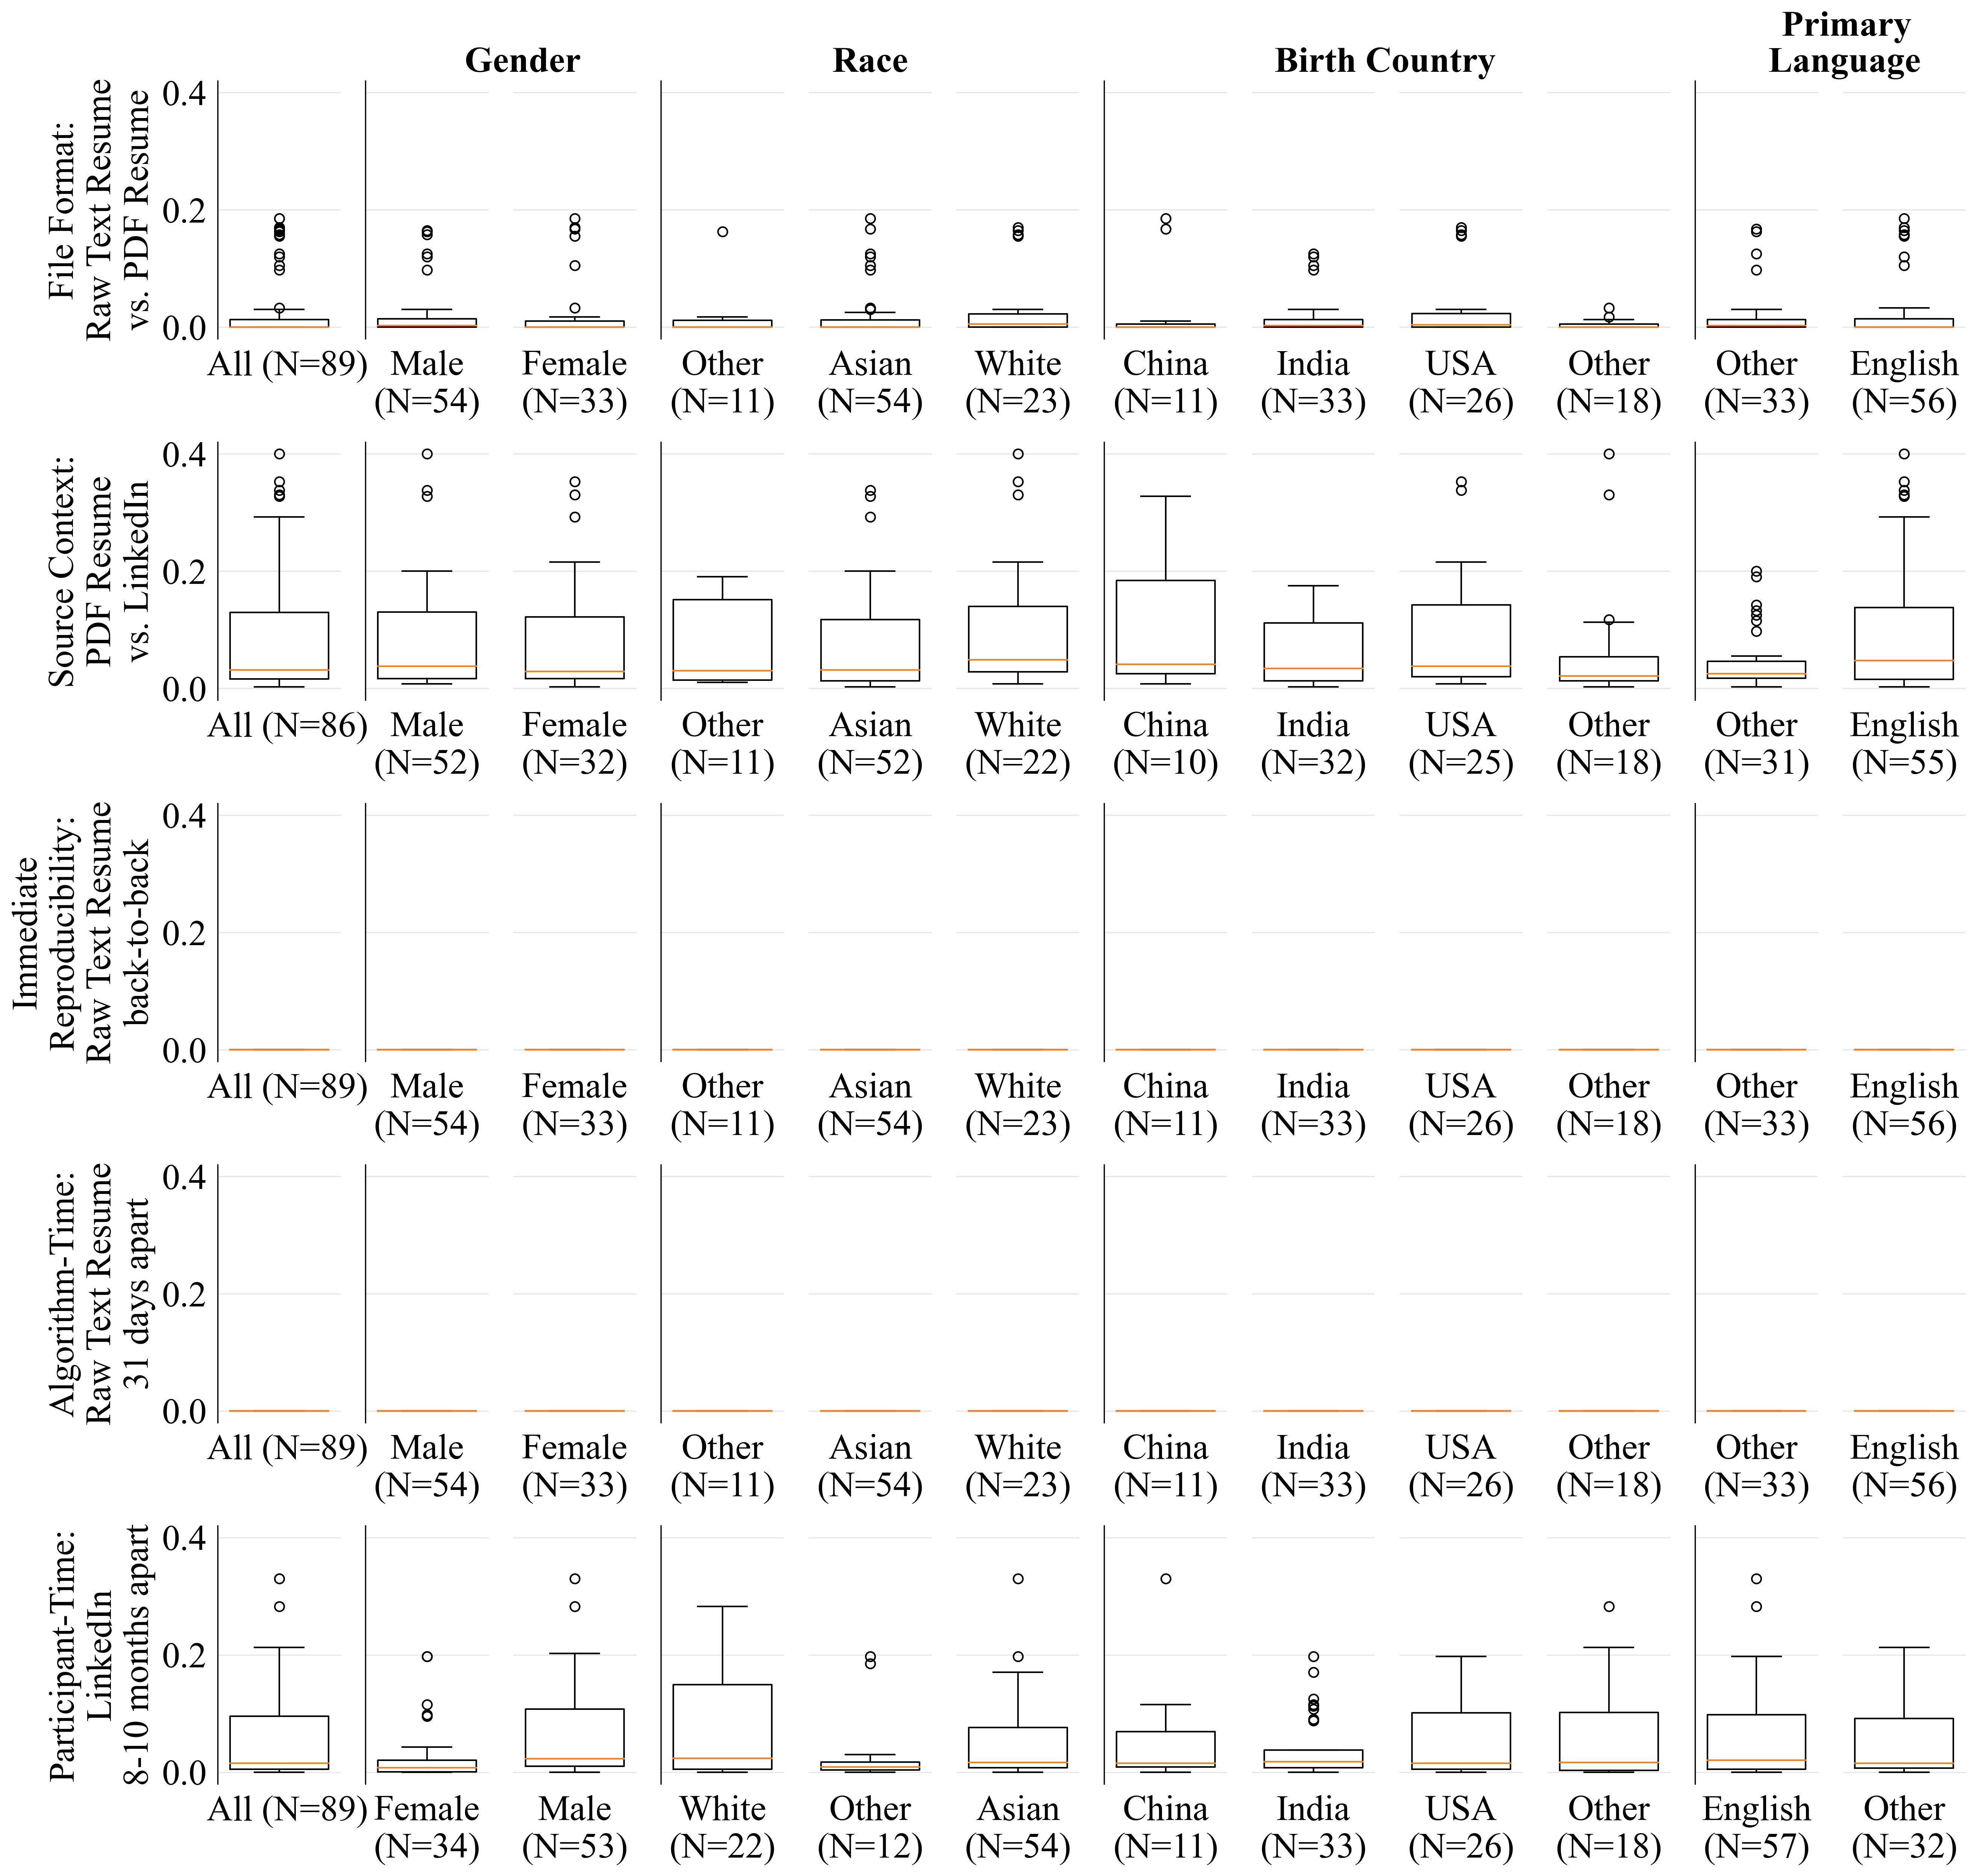

In [61]:
l1_boxplots(vendor='crystal', score_group_string='DISC', norm_method='max', 
            experiments = ['File Format: Raw Text Resume vs. PDF Resume (N=89)',
                          'Source Context: PDF Resume vs. LinkedIn (N=86)',
                          'Reproducibility: Raw Text Resume back-to-back (N=89)',
                          'Algorithm-Time: Raw Text Resume 31 days apart (N=89)',
                          'Participant-Time: LinkedIn 8-10 months apart (N=89)'],
               gender=True, race=True, country=True, lang=True)

In [62]:
# l1_boxplots(vendor='humantic', score_group_string='all', norm_method='max',
#            experiments = ['File Format: De-Identified Resume vs. DOCX Resume (N=89)',
#                           'URL Embedding: De-Identified Resume vs. URL-Embedded Resume (N=86)',
#                           'Source Context: De-Identified Resume vs. LinkedIn  (N=84)',
#                           'Source Context: LinkedIn vs. URL-Embedded Resume (N=83)',
#                           'Source Context: Original Resume vs. LinkedIn (N=84)',
#                           'Source Context: Original Resume vs. Twitter (N=20)',
#                           'Source Context: LinkedIn vs. Twitter (N=18)'],
#                gender=True, race=True, country=True, lang=True,
#                legend_bbox = (0.2, 0.06), print_y_axis=True)

In [63]:
# l1_boxplots(vendor='humantic', score_group_string='all', norm_method='max',
#            experiments = ['Reproducibility: De-Identified Resume back-to-back  (N=89)',
#                           'Algorithm-Time: De-Identified Resume 31 days apart (N=89)',
#                           'Participant-Time: LinkedIn 7-9 months apart (N=88)',
#                           'Participant-Time: Twitter 7-9 months apart (N=21)'],
#                gender=True, race=True, country=True, lang=True,
#                legend_bbox = (0.2, 0.02),
#                 ylim = (-0.020640000000000002, 0.43344),
#                 yticks = [0, 0.2, 0.4])

## Individual facet boxplots

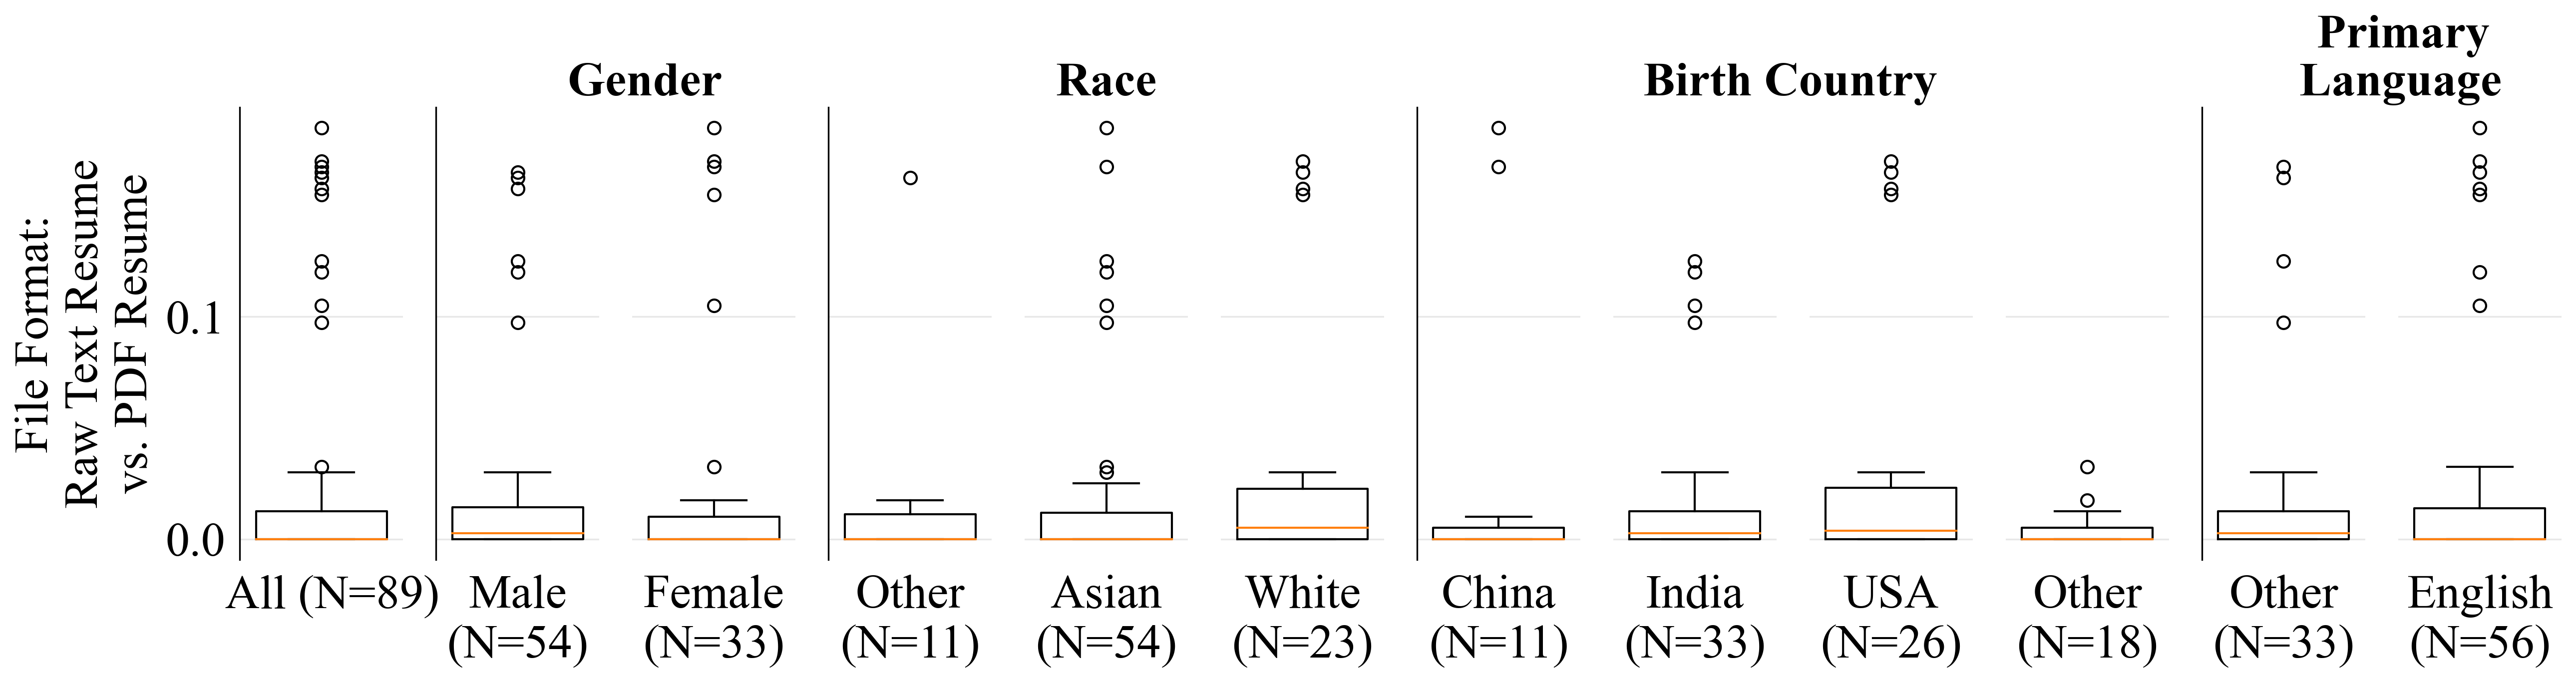

In [64]:
l1_boxplots(vendor='crystal', score_group_string='DISC', norm_method='max',
           experiments = ['File Format: Raw Text Resume vs. PDF Resume (N=89)'],
               gender=True, race=True, country=True, lang=True)

# l1_boxplots(vendor='humantic', score_group_string='all', norm_method='max',
#            experiments = ['File Format: De-Identified Resume vs. DOCX Resume (N=89)'],
#                gender=False, race=False, country=True, lang=False,
#            legend_bbox = (0.2, -0.25))

In [65]:
# l1_boxplots(vendor='humantic', score_group_string='all', norm_method='max',
#            experiments = ['URL Embedding: De-Identified Resume vs. URL-Embedded Resume (N=86)', 
#                          'Source Context: LinkedIn vs. URL-Embedded Resume (N=83)'],
#                gender=False, race=False, country=False, lang=False,
#            legend_bbox = (0.3, -0.8), horiz=True)

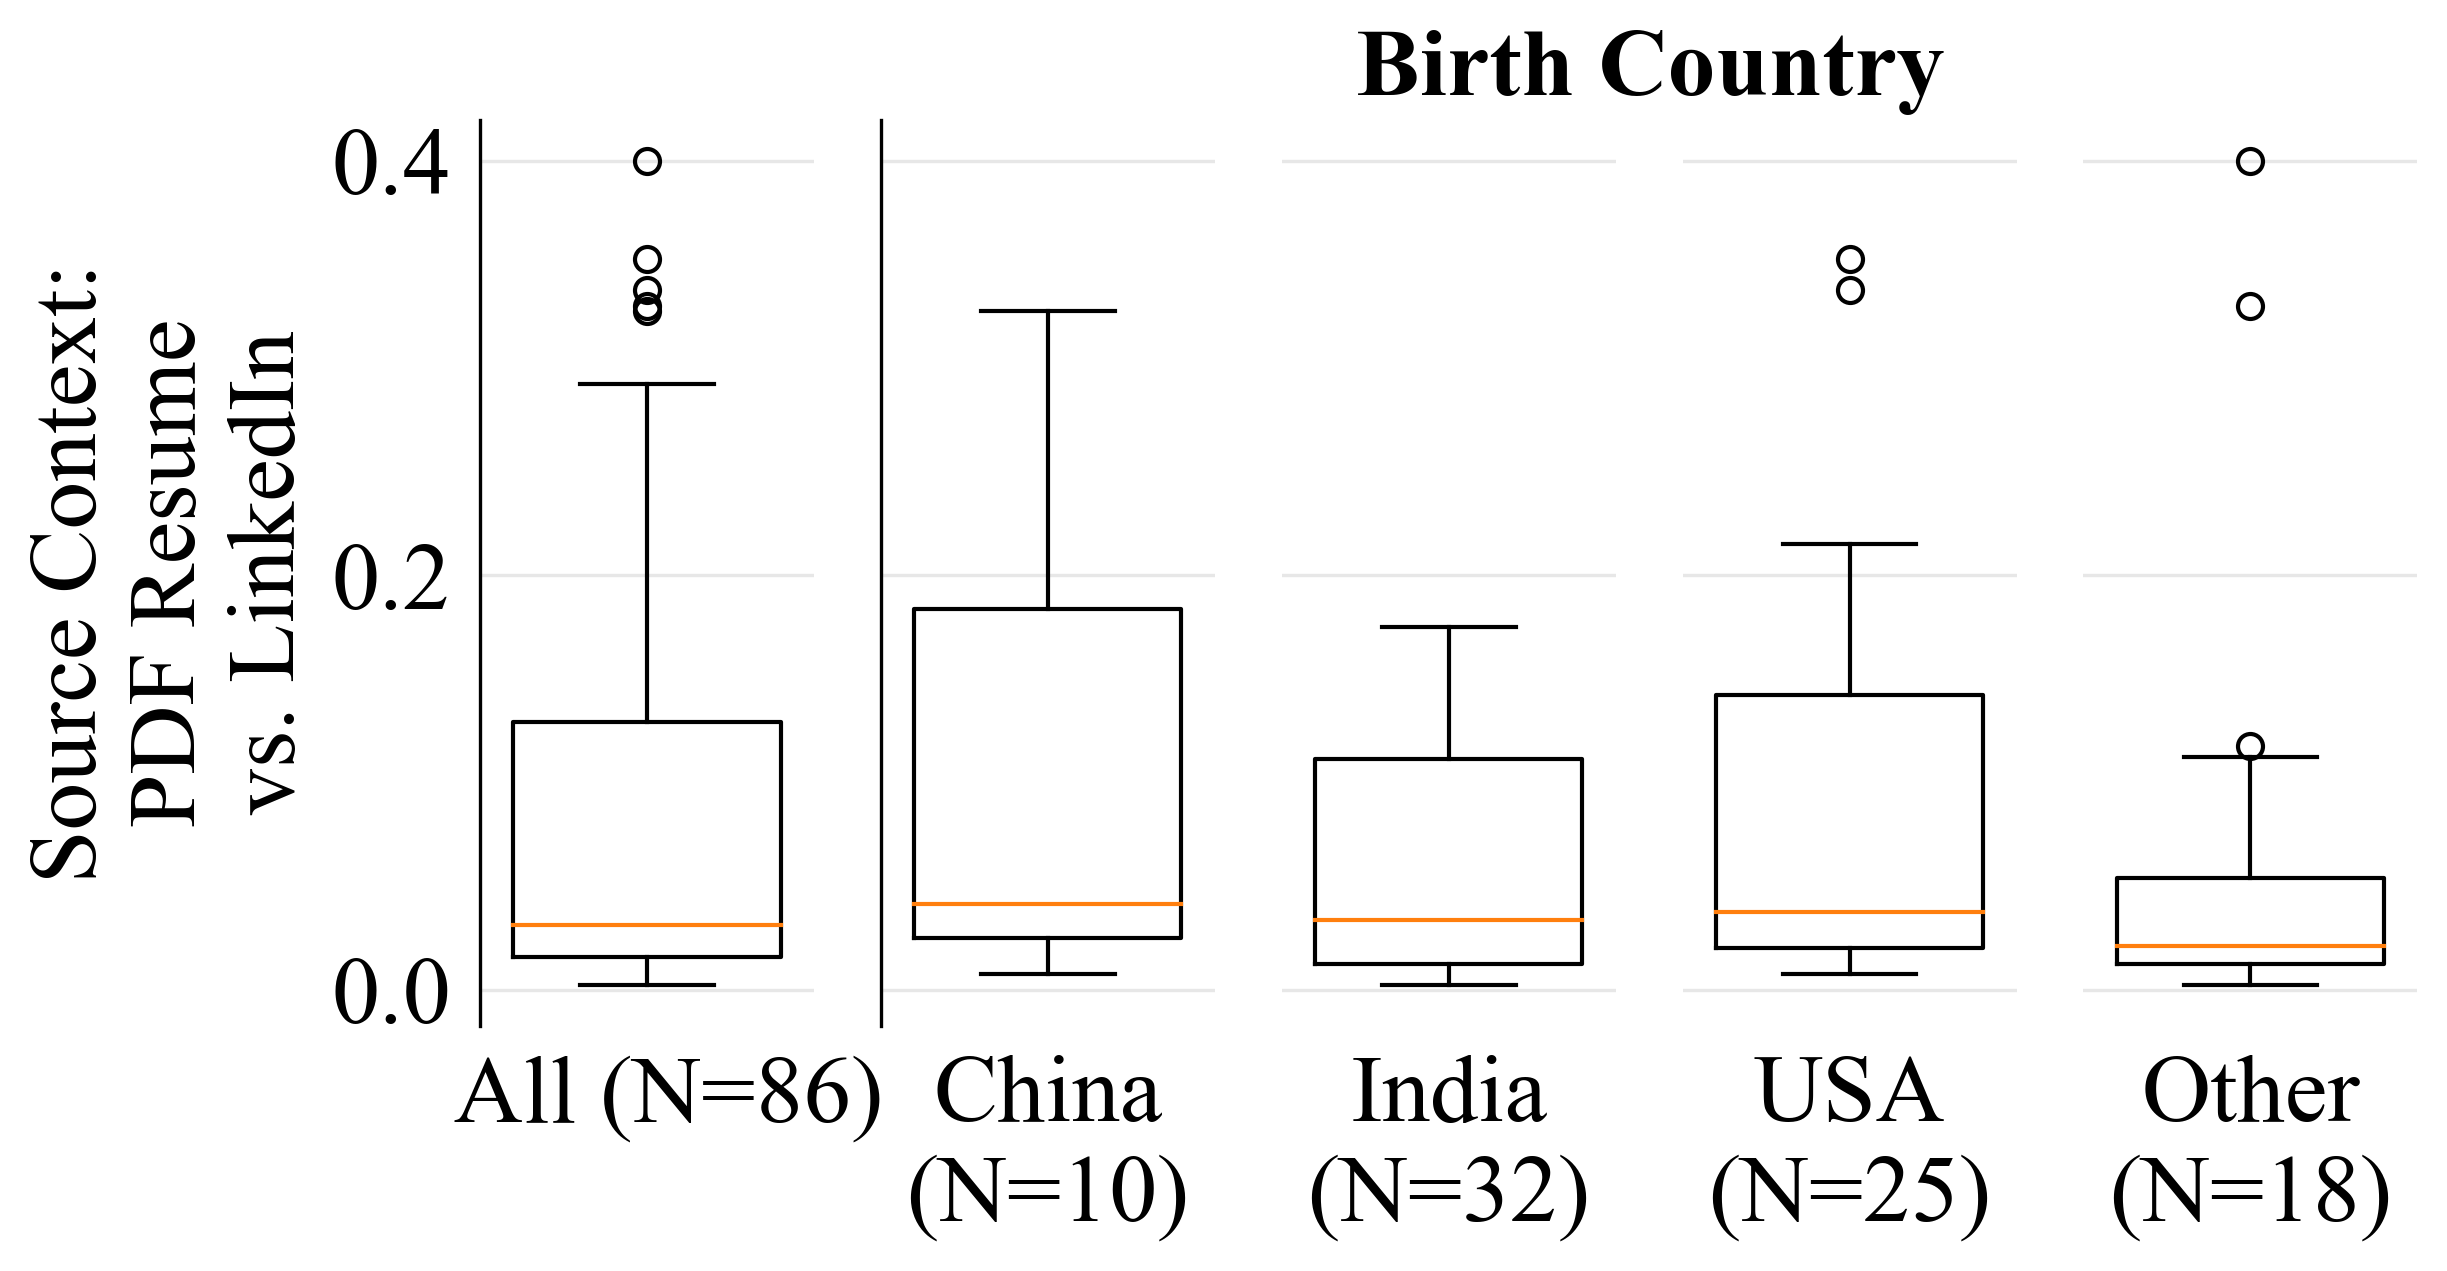

In [66]:
l1_boxplots(vendor='crystal', score_group_string='DISC', norm_method='max',
           experiments = ['Source Context: PDF Resume vs. LinkedIn (N=86)'],
               gender=False, race=False, country=True, lang=False)

# l1_boxplots(vendor='humantic', score_group_string='all', norm_method='max',
#            experiments = ['Source Context: De-Identified Resume vs. LinkedIn  (N=84)',
#                          'Source Context: Original Resume vs. LinkedIn (N=84)', 
#                          'Source Context: Original Resume vs. Twitter (N=20)',
#                          'Source Context: LinkedIn vs. Twitter (N=18)'],
#                gender=False, race=False, country=False, lang=False,
#                legend_bbox = (0.25, -0.8),
#            horiz=True)

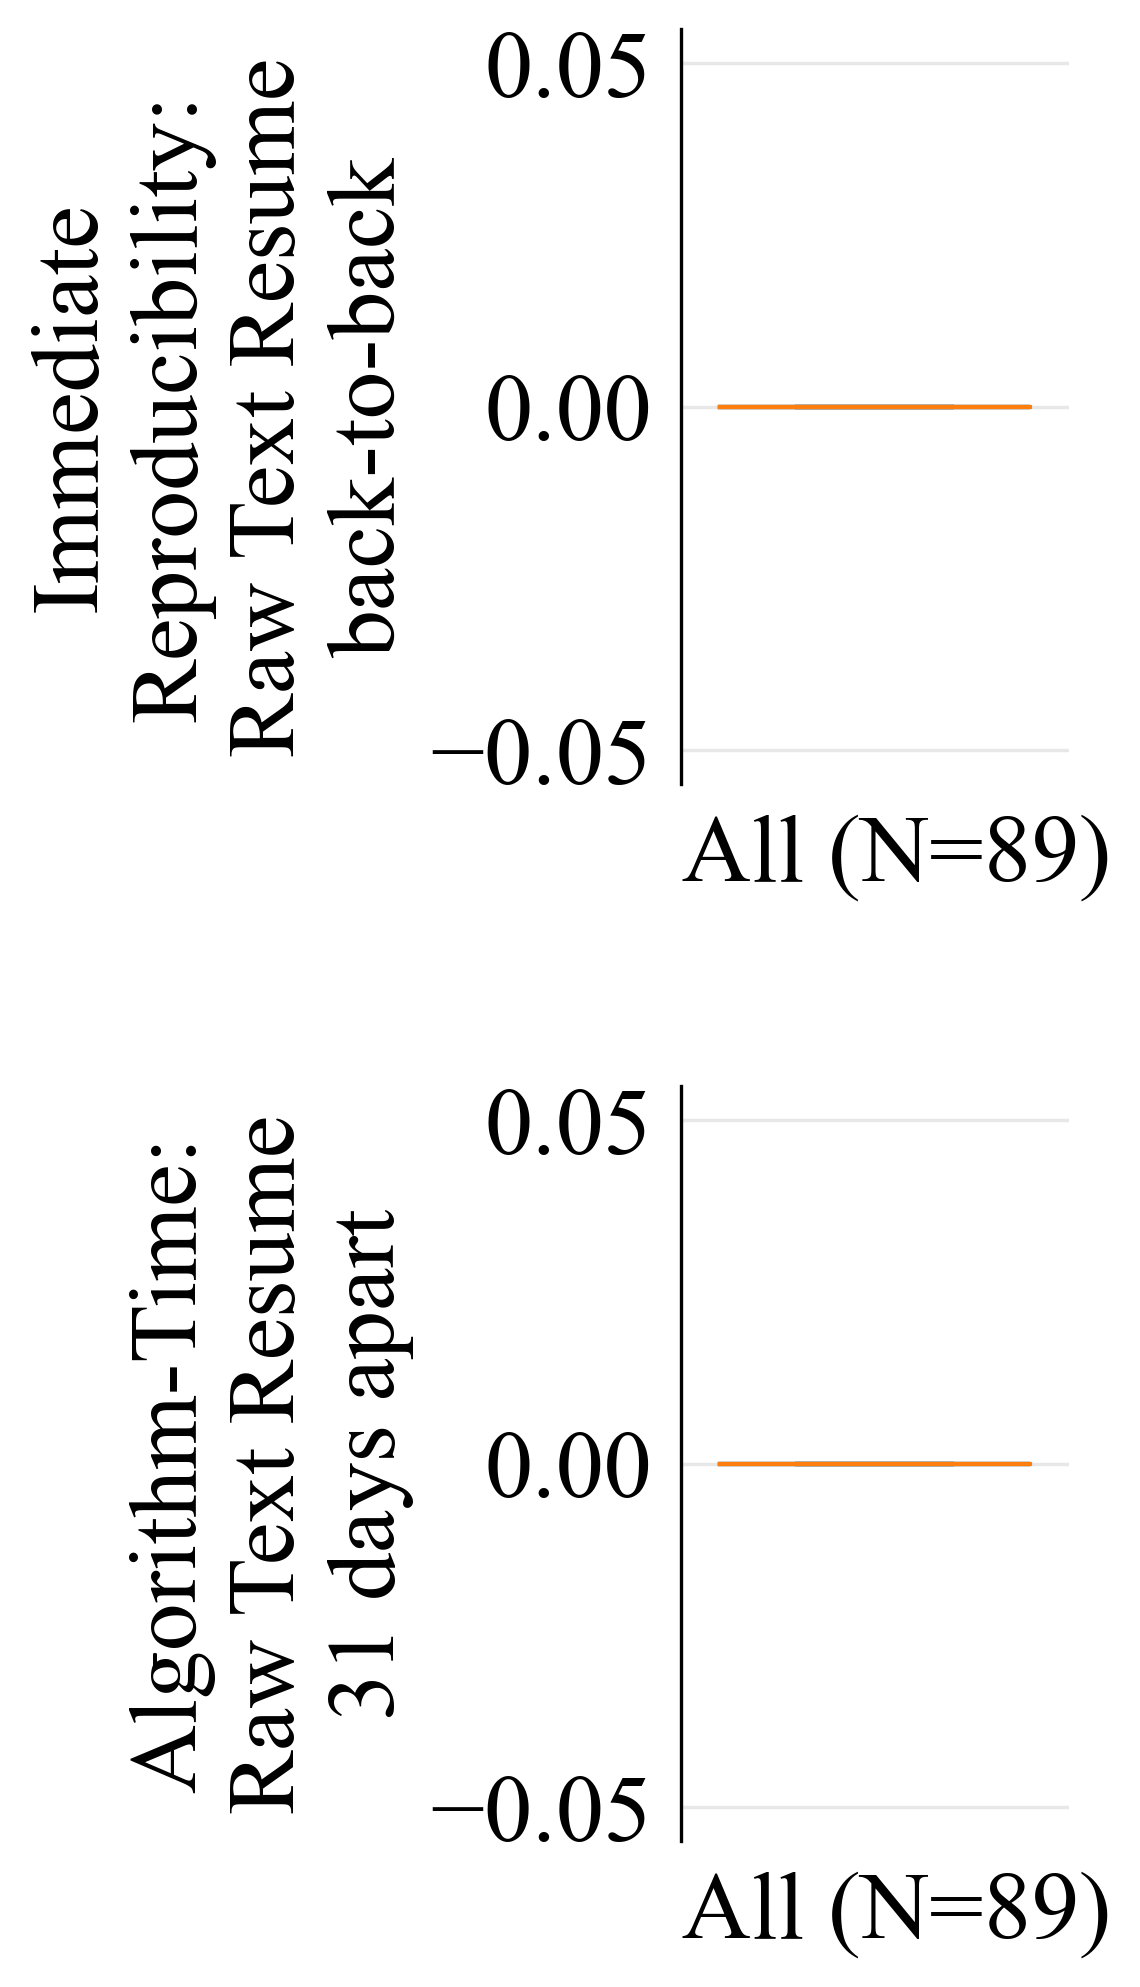

In [67]:
l1_boxplots(vendor='crystal', score_group_string='DISC', norm_method='max',
           experiments = ['Reproducibility: Raw Text Resume back-to-back (N=89)',
                          'Algorithm-Time: Raw Text Resume 31 days apart (N=89)'],
               gender=False, race=False, country=False, lang=False)

# l1_boxplots(vendor='humantic', score_group_string='all', norm_method='max',
#            experiments = ['Reproducibility: De-Identified Resume back-to-back  (N=89)',
#                           'Algorithm-Time: De-Identified Resume 31 days apart (N=89)'],
#                gender=False, race=True, country=True, lang=True)

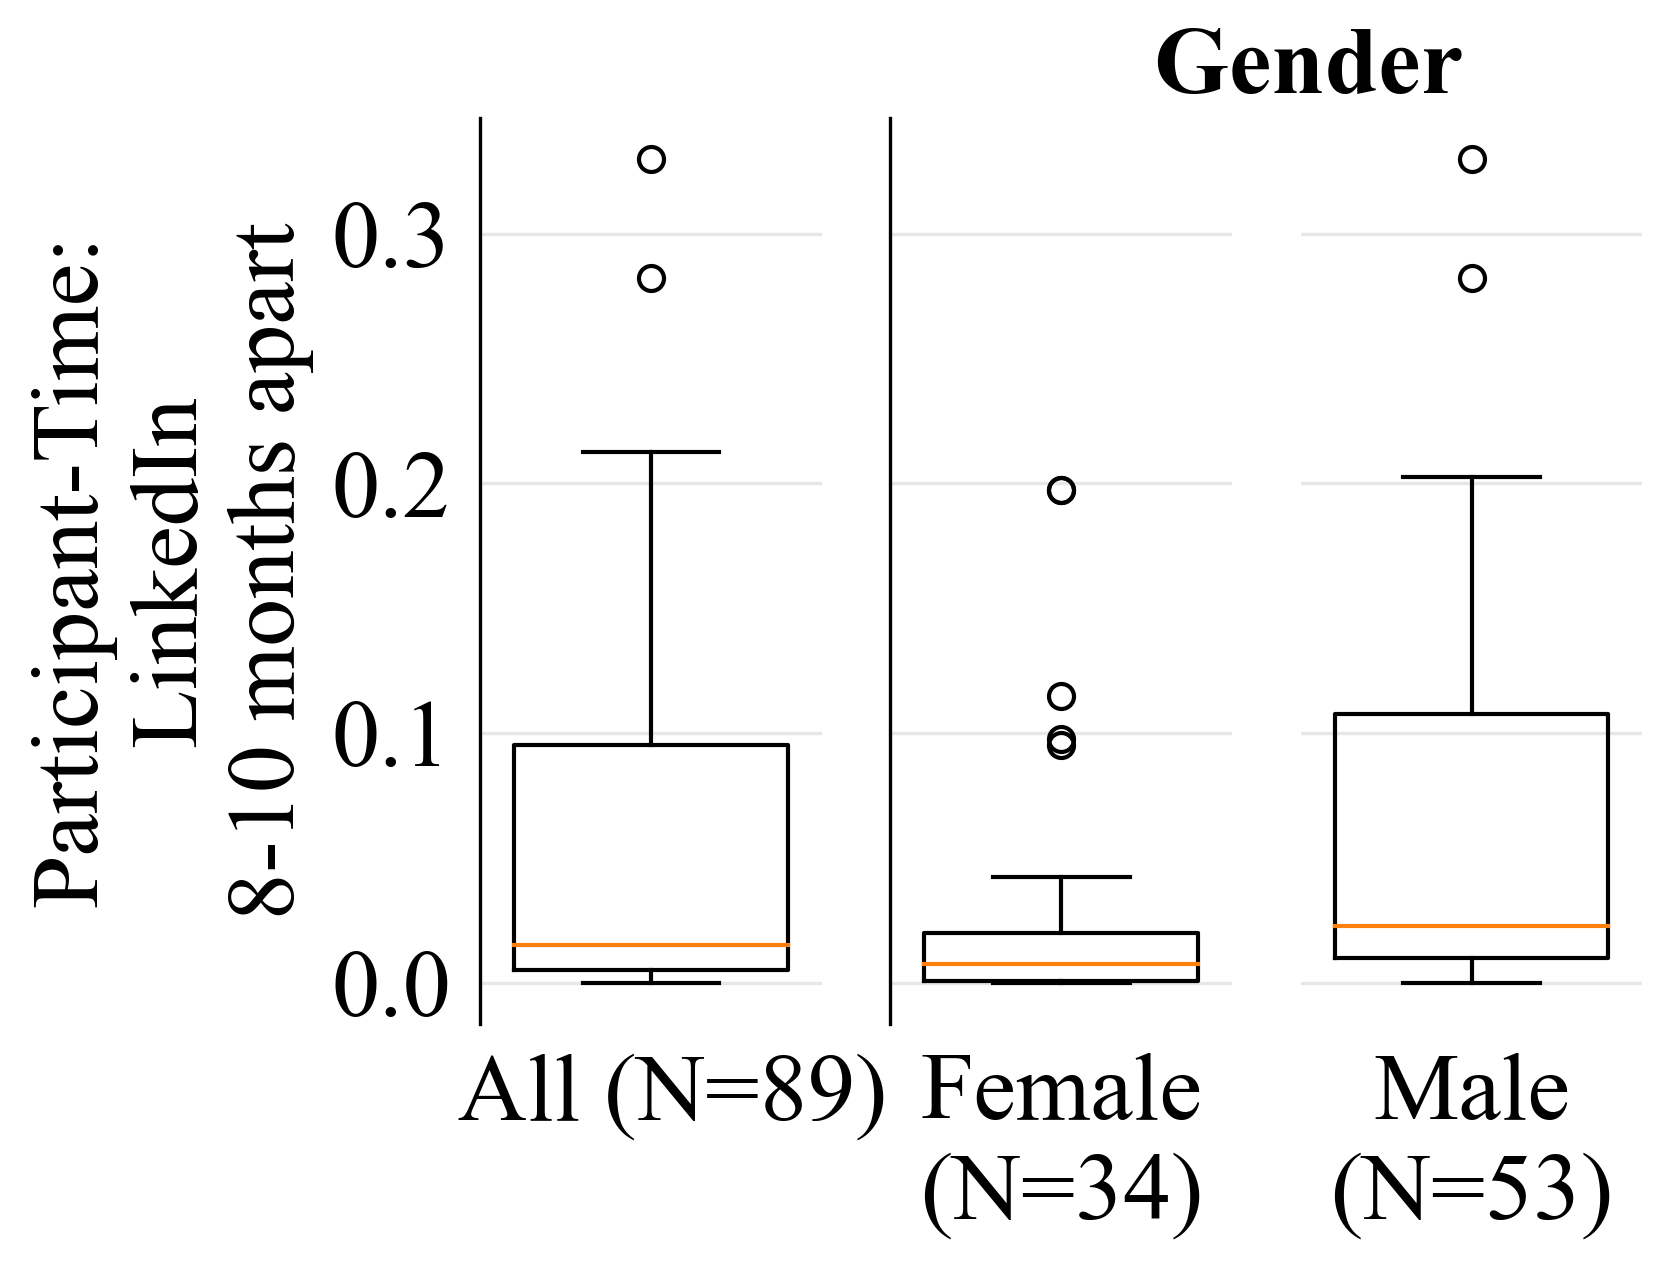

In [68]:
l1_boxplots(vendor='crystal', score_group_string='DISC', norm_method='max',
           experiments = ['Participant-Time: LinkedIn 8-10 months apart (N=89)'],
               gender=True, race=False, country=False, lang=False)

# l1_boxplots(vendor='humantic', score_group_string='all', norm_method='max',
#            experiments = ['Participant-Time: LinkedIn 7-9 months apart (N=88)',
#                           'Participant-Time: Twitter 7-9 months apart (N=21)'],
#                gender=False, race=True, country=False, lang=False)